In [481]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [482]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [483]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [484]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 3360
Total Drives: 86002
Total Plays: 608262


In [485]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 85466


In [486]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [487]:
# %%timeit
if 'EPA' not in pbp_data.columns:
    pbp_data["EPA"] = pbp_data.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)

In [488]:
pbp_data.head()

,index,away,clock.minutes,clock.seconds,defense,defense_score,distance,down,drive_id,home,...,offense,offense_score,period,play_text,play_type,ppa,yard_line,yards_gained,year,EPA
3,3,Northwestern State,14,55,Baylor,0,11.0,2,4008688761,Baylor,...,Northwestern State,0,1,De'Mard Llorens run for 8 yds to the NWSt 21,Rush,NaN,87,8,2016,1.225906
4,4,Northwestern State,14,55,Baylor,0,10.0,1,4008688761,Baylor,...,Northwestern State,0,1,De'Mard Llorens run for a loss of 1 yard to th...,Rush,NaN,86,-1,2016,-0.124202
5,5,Northwestern State,14,55,Baylor,0,3.0,3,4008688761,Baylor,...,Northwestern State,0,1,De'Mard Llorens run for no gain to the NWSt 21,Rush,NaN,79,0,2016,0.000000
6,6,Northwestern State,12,45,Northwestern State,0,4.0,2,4008688762,Baylor,...,Baylor,0,1,Shock Linwood run for 3 yds to the 50 yard line,Rush,NaN,47,3,2016,0.149962
7,7,Northwestern State,12,45,Northwestern State,0,11.0,3,4008688762,Baylor,...,Baylor,0,1,Shock Linwood run for 42 yds to the NWSt 18 fo...,Rush,NaN,40,42,2016,2.823846


In [489]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [490]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'AvgEPA', 'IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EPA.mean()

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_epa = team_off_plays.EPA.mean()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEPA" : [avg_epa]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'HavocRate': [havoc]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEPADiff, pbp_data.EPA.min()-pbp_data.EPA.max(), pbp_data.EPA.max()-pbp_data.EPA.min(), 0, 10)
    #return translate(team_stat_pack.IsoPPPDiff, pbp_data.EPA.min(), pbp_data.EPA.max(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 5)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,7) + translate(team_stat_pack.OppSRDiff, -1,1,0,3)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.05 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EPA' not in game_pbp.columns:
        game_pbp['EPA'] = game_pbp.apply(lambda x: ep_data.iloc[min(100, (x.yard_line + x.yards_gained))].ep - ep_data.iloc[x.yard_line].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,1.791667,-0.052381,0.118588,0.994779,-0.66,0.103211,0.124959,-0.040309,4.773447,0.046895
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-1.791667,0.052381,-0.118588,-0.994779,0.66,-0.103211,-0.124959,0.040309,4.726553,-0.046895


In [491]:
# %%timeit

stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/3360] Getting game information for ESPN game_id: 400869090
[1/3360] Started processing game information for ESPN game_id: 400869090
[1/3360] Completed processing game information for ESPN game_id: 400869090
[1/3360] Aggreggating game_id 400869090 to master data copy
[2/3360] Getting game information for ESPN game_id: 400869421
[2/3360] Started processing game information for ESPN game_id: 400869421
[2/3360] Completed processing game information for ESPN game_id: 400869421
[2/3360] Aggreggating game_id 400869421 to master data copy
[3/3360] Getting game information for ESPN game_id: 400869257
[3/3360] Started processing game information for ESPN game_id: 400869257
[3/3360] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/3360] Getting game information for ESPN game_id: 400869502
[4/3360] Started processing game information for ESPN game_id: 400869502
[4/3360] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/3360] Getting game information for ES

[35/3360] Completed processing game information for ESPN game_id: 400868976
[35/3360] Aggreggating game_id 400868976 to master data copy
[36/3360] Getting game information for ESPN game_id: 400869507
[36/3360] Started processing game information for ESPN game_id: 400869507
[36/3360] Completed processing game information for ESPN game_id: 400869507
[36/3360] Aggreggating game_id 400869507 to master data copy
[37/3360] Getting game information for ESPN game_id: 400869260
[37/3360] Started processing game information for ESPN game_id: 400869260
[37/3360] Completed processing game information for ESPN game_id: 400869260
[37/3360] Aggreggating game_id 400869260 to master data copy
[38/3360] Getting game information for ESPN game_id: 400869509
[38/3360] Started processing game information for ESPN game_id: 400869509
[38/3360] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/3360] Getting game information for ESPN game_id: 400869267
[39/3360] Started processing game infor

[72/3360] Completed processing game information for ESPN game_id: 400868957
[72/3360] Aggreggating game_id 400868957 to master data copy
[73/3360] Getting game information for ESPN game_id: 400869624
[73/3360] Started processing game information for ESPN game_id: 400869624
[73/3360] Skipping checking game_id 400869624 bc one of the teams isn't FBS
[74/3360] Getting game information for ESPN game_id: 400868969
[74/3360] Started processing game information for ESPN game_id: 400868969
[74/3360] Completed processing game information for ESPN game_id: 400868969
[74/3360] Aggreggating game_id 400868969 to master data copy
[75/3360] Getting game information for ESPN game_id: 400868887
[75/3360] Started processing game information for ESPN game_id: 400868887
[75/3360] Skipping checking game_id 400868887 bc one of the teams isn't FBS
[76/3360] Getting game information for ESPN game_id: 400869179
[76/3360] Started processing game information for ESPN game_id: 400869179
[76/3360] Completed proces

[108/3360] Completed processing game information for ESPN game_id: 400869101
[108/3360] Aggreggating game_id 400869101 to master data copy
[109/3360] Getting game information for ESPN game_id: 400869277
[109/3360] Started processing game information for ESPN game_id: 400869277
[109/3360] Completed processing game information for ESPN game_id: 400869277
[109/3360] Aggreggating game_id 400869277 to master data copy
[110/3360] Getting game information for ESPN game_id: 400869433
[110/3360] Started processing game information for ESPN game_id: 400869433
[110/3360] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[111/3360] Getting game information for ESPN game_id: 400868877
[111/3360] Started processing game information for ESPN game_id: 400868877
[111/3360] Completed processing game information for ESPN game_id: 400868877
[111/3360] Aggreggating game_id 400868877 to master data copy
[112/3360] Getting game information for ESPN game_id: 400868980
[112/3360] Started proces

[143/3360] Completed processing game information for ESPN game_id: 400869612
[143/3360] Aggreggating game_id 400869612 to master data copy
[144/3360] Getting game information for ESPN game_id: 400868981
[144/3360] Started processing game information for ESPN game_id: 400868981
[144/3360] Completed processing game information for ESPN game_id: 400868981
[144/3360] Aggreggating game_id 400868981 to master data copy
[145/3360] Getting game information for ESPN game_id: 400869357
[145/3360] Started processing game information for ESPN game_id: 400869357
[145/3360] Completed processing game information for ESPN game_id: 400869357
[145/3360] Aggreggating game_id 400869357 to master data copy
[146/3360] Getting game information for ESPN game_id: 400868888
[146/3360] Started processing game information for ESPN game_id: 400868888
[146/3360] Completed processing game information for ESPN game_id: 400868888
[146/3360] Aggreggating game_id 400868888 to master data copy
[147/3360] Getting game inf

[176/3360] Completed processing game information for ESPN game_id: 400869281
[176/3360] Aggreggating game_id 400869281 to master data copy
[177/3360] Getting game information for ESPN game_id: 400869519
[177/3360] Started processing game information for ESPN game_id: 400869519
[177/3360] Completed processing game information for ESPN game_id: 400869519
[177/3360] Aggreggating game_id 400869519 to master data copy
[178/3360] Getting game information for ESPN game_id: 400869520
[178/3360] Started processing game information for ESPN game_id: 400869520
[178/3360] Completed processing game information for ESPN game_id: 400869520
[178/3360] Aggreggating game_id 400869520 to master data copy
[179/3360] Getting game information for ESPN game_id: 400869001
[179/3360] Started processing game information for ESPN game_id: 400869001
[179/3360] Completed processing game information for ESPN game_id: 400869001
[179/3360] Aggreggating game_id 400869001 to master data copy
[180/3360] Getting game inf

[209/3360] Completed processing game information for ESPN game_id: 400868993
[209/3360] Aggreggating game_id 400868993 to master data copy
[210/3360] Getting game information for ESPN game_id: 400868996
[210/3360] Started processing game information for ESPN game_id: 400868996
[210/3360] Completed processing game information for ESPN game_id: 400868996
[210/3360] Aggreggating game_id 400868996 to master data copy
[211/3360] Getting game information for ESPN game_id: 400869521
[211/3360] Started processing game information for ESPN game_id: 400869521
[211/3360] Completed processing game information for ESPN game_id: 400869521
[211/3360] Aggreggating game_id 400869521 to master data copy
[212/3360] Getting game information for ESPN game_id: 400869522
[212/3360] Started processing game information for ESPN game_id: 400869522
[212/3360] Completed processing game information for ESPN game_id: 400869522
[212/3360] Aggreggating game_id 400869522 to master data copy
[213/3360] Getting game inf

[240/3360] Completed processing game information for ESPN game_id: 400869363
[240/3360] Aggreggating game_id 400869363 to master data copy
[241/3360] Getting game information for ESPN game_id: 400869204
[241/3360] Started processing game information for ESPN game_id: 400869204
[241/3360] Completed processing game information for ESPN game_id: 400869204
[241/3360] Aggreggating game_id 400869204 to master data copy
[242/3360] Getting game information for ESPN game_id: 400869203
[242/3360] Started processing game information for ESPN game_id: 400869203
[242/3360] Completed processing game information for ESPN game_id: 400869203
[242/3360] Aggreggating game_id 400869203 to master data copy
[243/3360] Getting game information for ESPN game_id: 400869288
[243/3360] Started processing game information for ESPN game_id: 400869288
[243/3360] Completed processing game information for ESPN game_id: 400869288
[243/3360] Aggreggating game_id 400869288 to master data copy
[244/3360] Getting game inf

[271/3360] Completed processing game information for ESPN game_id: 400869816
[271/3360] Aggreggating game_id 400869816 to master data copy
[272/3360] Getting game information for ESPN game_id: 400869365
[272/3360] Started processing game information for ESPN game_id: 400869365
[272/3360] Completed processing game information for ESPN game_id: 400869365
[272/3360] Aggreggating game_id 400869365 to master data copy
[273/3360] Getting game information for ESPN game_id: 400868913
[273/3360] Started processing game information for ESPN game_id: 400868913
[273/3360] Completed processing game information for ESPN game_id: 400868913
[273/3360] Aggreggating game_id 400868913 to master data copy
[274/3360] Getting game information for ESPN game_id: 400869815
[274/3360] Started processing game information for ESPN game_id: 400869815
[274/3360] Skipping checking game_id 400869815 bc one of the teams isn't FBS
[275/3360] Getting game information for ESPN game_id: 400869605
[275/3360] Started proces

[303/3360] Completed processing game information for ESPN game_id: 400869620
[303/3360] Aggreggating game_id 400869620 to master data copy
[304/3360] Getting game information for ESPN game_id: 400869454
[304/3360] Started processing game information for ESPN game_id: 400869454
[304/3360] Completed processing game information for ESPN game_id: 400869454
[304/3360] Aggreggating game_id 400869454 to master data copy
[305/3360] Getting game information for ESPN game_id: 400869294
[305/3360] Started processing game information for ESPN game_id: 400869294
[305/3360] Completed processing game information for ESPN game_id: 400869294
[305/3360] Aggreggating game_id 400869294 to master data copy
[306/3360] Getting game information for ESPN game_id: 400869296
[306/3360] Started processing game information for ESPN game_id: 400869296
[306/3360] Completed processing game information for ESPN game_id: 400869296
[306/3360] Aggreggating game_id 400869296 to master data copy
[307/3360] Getting game inf

[334/3360] Completed processing game information for ESPN game_id: 400869371
[334/3360] Aggreggating game_id 400869371 to master data copy
[335/3360] Getting game information for ESPN game_id: 400869010
[335/3360] Started processing game information for ESPN game_id: 400869010
[335/3360] Completed processing game information for ESPN game_id: 400869010
[335/3360] Aggreggating game_id 400869010 to master data copy
[336/3360] Getting game information for ESPN game_id: 400869374
[336/3360] Started processing game information for ESPN game_id: 400869374
[336/3360] Completed processing game information for ESPN game_id: 400869374
[336/3360] Aggreggating game_id 400869374 to master data copy
[337/3360] Getting game information for ESPN game_id: 400869014
[337/3360] Started processing game information for ESPN game_id: 400869014
[337/3360] Completed processing game information for ESPN game_id: 400869014
[337/3360] Aggreggating game_id 400869014 to master data copy
[338/3360] Getting game inf

[364/3360] Completed processing game information for ESPN game_id: 400869381
[364/3360] Aggreggating game_id 400869381 to master data copy
[365/3360] Getting game information for ESPN game_id: 400869021
[365/3360] Started processing game information for ESPN game_id: 400869021
[365/3360] Completed processing game information for ESPN game_id: 400869021
[365/3360] Aggreggating game_id 400869021 to master data copy
[366/3360] Getting game information for ESPN game_id: 400868951
[366/3360] Started processing game information for ESPN game_id: 400868951
[366/3360] Completed processing game information for ESPN game_id: 400868951
[366/3360] Aggreggating game_id 400868951 to master data copy
[367/3360] Getting game information for ESPN game_id: 400869458
[367/3360] Started processing game information for ESPN game_id: 400869458
[367/3360] Completed processing game information for ESPN game_id: 400869458
[367/3360] Aggreggating game_id 400869458 to master data copy
[368/3360] Getting game inf

[394/3360] Completed processing game information for ESPN game_id: 400869133
[394/3360] Aggreggating game_id 400869133 to master data copy
[395/3360] Getting game information for ESPN game_id: 400869378
[395/3360] Started processing game information for ESPN game_id: 400869378
[395/3360] Completed processing game information for ESPN game_id: 400869378
[395/3360] Aggreggating game_id 400869378 to master data copy
[396/3360] Getting game information for ESPN game_id: 400869722
[396/3360] Started processing game information for ESPN game_id: 400869722
[396/3360] Completed processing game information for ESPN game_id: 400869722
[396/3360] Aggreggating game_id 400869722 to master data copy
[397/3360] Getting game information for ESPN game_id: 400869134
[397/3360] Started processing game information for ESPN game_id: 400869134
[397/3360] Completed processing game information for ESPN game_id: 400869134
[397/3360] Aggreggating game_id 400869134 to master data copy
[398/3360] Getting game inf

[425/3360] Completed processing game information for ESPN game_id: 400868963
[425/3360] Aggreggating game_id 400868963 to master data copy
[426/3360] Getting game information for ESPN game_id: 400869136
[426/3360] Started processing game information for ESPN game_id: 400869136
[426/3360] Completed processing game information for ESPN game_id: 400869136
[426/3360] Aggreggating game_id 400869136 to master data copy
[427/3360] Getting game information for ESPN game_id: 400869219
[427/3360] Started processing game information for ESPN game_id: 400869219
[427/3360] Completed processing game information for ESPN game_id: 400869219
[427/3360] Aggreggating game_id 400869219 to master data copy
[428/3360] Getting game information for ESPN game_id: 400869672
[428/3360] Started processing game information for ESPN game_id: 400869672
[428/3360] Completed processing game information for ESPN game_id: 400869672
[428/3360] Aggreggating game_id 400869672 to master data copy
[429/3360] Getting game inf

[454/3360] Completed processing game information for ESPN game_id: 400869137
[454/3360] Aggreggating game_id 400869137 to master data copy
[455/3360] Getting game information for ESPN game_id: 400869220
[455/3360] Started processing game information for ESPN game_id: 400869220
[455/3360] Completed processing game information for ESPN game_id: 400869220
[455/3360] Aggreggating game_id 400869220 to master data copy
[456/3360] Getting game information for ESPN game_id: 400869138
[456/3360] Started processing game information for ESPN game_id: 400869138
[456/3360] Completed processing game information for ESPN game_id: 400869138
[456/3360] Aggreggating game_id 400869138 to master data copy
[457/3360] Getting game information for ESPN game_id: 400869223
[457/3360] Started processing game information for ESPN game_id: 400869223
[457/3360] Completed processing game information for ESPN game_id: 400869223
[457/3360] Aggreggating game_id 400869223 to master data copy
[458/3360] Getting game inf

[485/3360] Completed processing game information for ESPN game_id: 400869677
[485/3360] Aggreggating game_id 400869677 to master data copy
[486/3360] Getting game information for ESPN game_id: 400869628
[486/3360] Started processing game information for ESPN game_id: 400869628
[486/3360] Completed processing game information for ESPN game_id: 400869628
[486/3360] Aggreggating game_id 400869628 to master data copy
[487/3360] Getting game information for ESPN game_id: 400869314
[487/3360] Started processing game information for ESPN game_id: 400869314
[487/3360] Completed processing game information for ESPN game_id: 400869314
[487/3360] Aggreggating game_id 400869314 to master data copy
[488/3360] Getting game information for ESPN game_id: 400869546
[488/3360] Started processing game information for ESPN game_id: 400869546
[488/3360] Completed processing game information for ESPN game_id: 400869546
[488/3360] Aggreggating game_id 400869546 to master data copy
[489/3360] Getting game inf

[516/3360] Completed processing game information for ESPN game_id: 400869471
[516/3360] Aggreggating game_id 400869471 to master data copy
[517/3360] Getting game information for ESPN game_id: 400869318
[517/3360] Started processing game information for ESPN game_id: 400869318
[517/3360] Completed processing game information for ESPN game_id: 400869318
[517/3360] Aggreggating game_id 400869318 to master data copy
[518/3360] Getting game information for ESPN game_id: 400869317
[518/3360] Started processing game information for ESPN game_id: 400869317
[518/3360] Completed processing game information for ESPN game_id: 400869317
[518/3360] Aggreggating game_id 400869317 to master data copy
[519/3360] Getting game information for ESPN game_id: 400869835
[519/3360] Started processing game information for ESPN game_id: 400869835
[519/3360] Completed processing game information for ESPN game_id: 400869835
[519/3360] Aggreggating game_id 400869835 to master data copy
[520/3360] Getting game inf

[546/3360] Completed processing game information for ESPN game_id: 400868881
[546/3360] Aggreggating game_id 400868881 to master data copy
[547/3360] Getting game information for ESPN game_id: 400869550
[547/3360] Started processing game information for ESPN game_id: 400869550
[547/3360] Completed processing game information for ESPN game_id: 400869550
[547/3360] Aggreggating game_id 400869550 to master data copy
[548/3360] Getting game information for ESPN game_id: 400869392
[548/3360] Started processing game information for ESPN game_id: 400869392
[548/3360] Completed processing game information for ESPN game_id: 400869392
[548/3360] Aggreggating game_id 400869392 to master data copy
[549/3360] Getting game information for ESPN game_id: 400869553
[549/3360] Started processing game information for ESPN game_id: 400869553
[549/3360] Completed processing game information for ESPN game_id: 400869553
[549/3360] Aggreggating game_id 400869553 to master data copy
[550/3360] Getting game inf

[576/3360] Completed processing game information for ESPN game_id: 400869150
[576/3360] Aggreggating game_id 400869150 to master data copy
[577/3360] Getting game information for ESPN game_id: 400869324
[577/3360] Started processing game information for ESPN game_id: 400869324
[577/3360] Completed processing game information for ESPN game_id: 400869324
[577/3360] Aggreggating game_id 400869324 to master data copy
[578/3360] Getting game information for ESPN game_id: 400869554
[578/3360] Started processing game information for ESPN game_id: 400869554
[578/3360] Completed processing game information for ESPN game_id: 400869554
[578/3360] Aggreggating game_id 400869554 to master data copy
[579/3360] Getting game information for ESPN game_id: 400869236
[579/3360] Started processing game information for ESPN game_id: 400869236
[579/3360] Completed processing game information for ESPN game_id: 400869236
[579/3360] Aggreggating game_id 400869236 to master data copy
[580/3360] Getting game inf

[606/3360] Completed processing game information for ESPN game_id: 400869685
[606/3360] Aggreggating game_id 400869685 to master data copy
[607/3360] Getting game information for ESPN game_id: 400869478
[607/3360] Started processing game information for ESPN game_id: 400869478
[607/3360] Completed processing game information for ESPN game_id: 400869478
[607/3360] Aggreggating game_id 400869478 to master data copy
[608/3360] Getting game information for ESPN game_id: 400869048
[608/3360] Started processing game information for ESPN game_id: 400869048
[608/3360] Skipping checking game_id 400869048 bc one of the teams isn't FBS
[609/3360] Getting game information for ESPN game_id: 400869151
[609/3360] Started processing game information for ESPN game_id: 400869151
[609/3360] Completed processing game information for ESPN game_id: 400869151
[609/3360] Aggreggating game_id 400869151 to master data copy
[610/3360] Getting game information for ESPN game_id: 400869556
[610/3360] Started proces

[637/3360] Completed processing game information for ESPN game_id: 400869155
[637/3360] Aggreggating game_id 400869155 to master data copy
[638/3360] Getting game information for ESPN game_id: 400869484
[638/3360] Started processing game information for ESPN game_id: 400869484
[638/3360] Completed processing game information for ESPN game_id: 400869484
[638/3360] Aggreggating game_id 400869484 to master data copy
[639/3360] Getting game information for ESPN game_id: 400869051
[639/3360] Started processing game information for ESPN game_id: 400869051
[639/3360] Completed processing game information for ESPN game_id: 400869051
[639/3360] Aggreggating game_id 400869051 to master data copy
[640/3360] Getting game information for ESPN game_id: 400869049
[640/3360] Started processing game information for ESPN game_id: 400869049
[640/3360] Completed processing game information for ESPN game_id: 400869049
[640/3360] Aggreggating game_id 400869049 to master data copy
[641/3360] Getting game inf

[668/3360] Completed processing game information for ESPN game_id: 400869560
[668/3360] Aggreggating game_id 400869560 to master data copy
[669/3360] Getting game information for ESPN game_id: 400869244
[669/3360] Started processing game information for ESPN game_id: 400869244
[669/3360] Completed processing game information for ESPN game_id: 400869244
[669/3360] Aggreggating game_id 400869244 to master data copy
[670/3360] Getting game information for ESPN game_id: 400869406
[670/3360] Started processing game information for ESPN game_id: 400869406
[670/3360] Completed processing game information for ESPN game_id: 400869406
[670/3360] Aggreggating game_id 400869406 to master data copy
[671/3360] Getting game information for ESPN game_id: 400869842
[671/3360] Started processing game information for ESPN game_id: 400869842
Could not find drive data for game_id 400869842 locally, checking CFB Data API
Could not find drive data for game_id 400869842 bc of issues with 2016 data source, bai

[698/3360] Completed processing game information for ESPN game_id: 400869649
[698/3360] Aggreggating game_id 400869649 to master data copy
[699/3360] Getting game information for ESPN game_id: 400869698
[699/3360] Started processing game information for ESPN game_id: 400869698
[699/3360] Completed processing game information for ESPN game_id: 400869698
[699/3360] Aggreggating game_id 400869698 to master data copy
[700/3360] Getting game information for ESPN game_id: 400869623
[700/3360] Started processing game information for ESPN game_id: 400869623
[700/3360] Completed processing game information for ESPN game_id: 400869623
[700/3360] Aggreggating game_id 400869623 to master data copy
[701/3360] Getting game information for ESPN game_id: 400869697
[701/3360] Started processing game information for ESPN game_id: 400869697
[701/3360] Completed processing game information for ESPN game_id: 400869697
[701/3360] Aggreggating game_id 400869697 to master data copy
[702/3360] Getting game inf

[728/3360] Completed processing game information for ESPN game_id: 400869164
[728/3360] Aggreggating game_id 400869164 to master data copy
[729/3360] Getting game information for ESPN game_id: 400869493
[729/3360] Started processing game information for ESPN game_id: 400869493
[729/3360] Completed processing game information for ESPN game_id: 400869493
[729/3360] Aggreggating game_id 400869493 to master data copy
[730/3360] Getting game information for ESPN game_id: 400869063
[730/3360] Started processing game information for ESPN game_id: 400869063
[730/3360] Skipping checking game_id 400869063 bc one of the teams isn't FBS
[731/3360] Getting game information for ESPN game_id: 400922541
[731/3360] Started processing game information for ESPN game_id: 400922541
[731/3360] Completed processing game information for ESPN game_id: 400922541
[731/3360] Aggreggating game_id 400922541 to master data copy
[732/3360] Getting game information for ESPN game_id: 400869249
[732/3360] Started proces

[759/3360] Completed processing game information for ESPN game_id: 400869339
[759/3360] Aggreggating game_id 400869339 to master data copy
[760/3360] Getting game information for ESPN game_id: 400869568
[760/3360] Started processing game information for ESPN game_id: 400869568
[760/3360] Completed processing game information for ESPN game_id: 400869568
[760/3360] Aggreggating game_id 400869568 to master data copy
[761/3360] Getting game information for ESPN game_id: 400869497
[761/3360] Started processing game information for ESPN game_id: 400869497
[761/3360] Completed processing game information for ESPN game_id: 400869497
[761/3360] Aggreggating game_id 400869497 to master data copy
[762/3360] Getting game information for ESPN game_id: 400869338
[762/3360] Started processing game information for ESPN game_id: 400869338
[762/3360] Completed processing game information for ESPN game_id: 400869338
[762/3360] Aggreggating game_id 400869338 to master data copy
[763/3360] Getting game inf

[790/3360] Completed processing game information for ESPN game_id: 400869572
[790/3360] Aggreggating game_id 400869572 to master data copy
[791/3360] Getting game information for ESPN game_id: 400869499
[791/3360] Started processing game information for ESPN game_id: 400869499
[791/3360] Completed processing game information for ESPN game_id: 400869499
[791/3360] Aggreggating game_id 400869499 to master data copy
[792/3360] Getting game information for ESPN game_id: 400869416
[792/3360] Started processing game information for ESPN game_id: 400869416
[792/3360] Completed processing game information for ESPN game_id: 400869416
[792/3360] Aggreggating game_id 400869416 to master data copy
[793/3360] Getting game information for ESPN game_id: 400869255
[793/3360] Started processing game information for ESPN game_id: 400869255
[793/3360] Completed processing game information for ESPN game_id: 400869255
[793/3360] Aggreggating game_id 400869255 to master data copy
[794/3360] Getting game inf

[821/3360] Completed processing game information for ESPN game_id: 400869611
[821/3360] Aggreggating game_id 400869611 to master data copy
[822/3360] Getting game information for ESPN game_id: 400869618
[822/3360] Started processing game information for ESPN game_id: 400869618
[822/3360] Completed processing game information for ESPN game_id: 400869618
[822/3360] Aggreggating game_id 400869618 to master data copy
[823/3360] Getting game information for ESPN game_id: 400869859
[823/3360] Started processing game information for ESPN game_id: 400869859
[823/3360] Completed processing game information for ESPN game_id: 400869859
[823/3360] Aggreggating game_id 400869859 to master data copy
[824/3360] Getting game information for ESPN game_id: 400869858
[824/3360] Started processing game information for ESPN game_id: 400869858
[824/3360] Completed processing game information for ESPN game_id: 400869858
[824/3360] Aggreggating game_id 400869858 to master data copy
[825/3360] Getting game inf

[856/3360] Completed processing game information for ESPN game_id: 400935250
[856/3360] Aggreggating game_id 400935250 to master data copy
[857/3360] Getting game information for ESPN game_id: 400938592
[857/3360] Started processing game information for ESPN game_id: 400938592
[857/3360] Completed processing game information for ESPN game_id: 400938592
[857/3360] Aggreggating game_id 400938592 to master data copy
[858/3360] Getting game information for ESPN game_id: 400935249
[858/3360] Started processing game information for ESPN game_id: 400935249
[858/3360] Completed processing game information for ESPN game_id: 400935249
[858/3360] Aggreggating game_id 400935249 to master data copy
[859/3360] Getting game information for ESPN game_id: 400935231
[859/3360] Started processing game information for ESPN game_id: 400935231
[859/3360] Completed processing game information for ESPN game_id: 400935231
[859/3360] Aggreggating game_id 400935231 to master data copy
[860/3360] Getting game inf

[889/3360] Completed processing game information for ESPN game_id: 400933831
[889/3360] Aggreggating game_id 400933831 to master data copy
[890/3360] Getting game information for ESPN game_id: 400938594
[890/3360] Started processing game information for ESPN game_id: 400938594
[890/3360] Completed processing game information for ESPN game_id: 400938594
[890/3360] Aggreggating game_id 400938594 to master data copy
[891/3360] Getting game information for ESPN game_id: 400938595
[891/3360] Started processing game information for ESPN game_id: 400938595
[891/3360] Skipping checking game_id 400938595 bc one of the teams isn't FBS
[892/3360] Getting game information for ESPN game_id: 400944829
[892/3360] Started processing game information for ESPN game_id: 400944829
[892/3360] Skipping checking game_id 400944829 bc one of the teams isn't FBS
[893/3360] Getting game information for ESPN game_id: 400944892
[893/3360] Started processing game information for ESPN game_id: 400944892
[893/3360] S

Could not find drive data for game_id 400935239 on CFB Data API, bailing out
[926/3360] Got 'None' for game_id 400935239's box score, skipping processing
[927/3360] Getting game information for ESPN game_id: 400934503
[927/3360] Started processing game information for ESPN game_id: 400934503
[927/3360] Completed processing game information for ESPN game_id: 400934503
[927/3360] Aggreggating game_id 400934503 to master data copy
[928/3360] Getting game information for ESPN game_id: 400934501
[928/3360] Started processing game information for ESPN game_id: 400934501
[928/3360] Completed processing game information for ESPN game_id: 400934501
[928/3360] Aggreggating game_id 400934501 to master data copy
[929/3360] Getting game information for ESPN game_id: 400935243
[929/3360] Started processing game information for ESPN game_id: 400935243
[929/3360] Completed processing game information for ESPN game_id: 400935243
[929/3360] Aggreggating game_id 400935243 to master data copy
[930/3360] G

[959/3360] Completed processing game information for ESPN game_id: 400933841
[959/3360] Aggreggating game_id 400933841 to master data copy
[960/3360] Getting game information for ESPN game_id: 400933851
[960/3360] Started processing game information for ESPN game_id: 400933851
[960/3360] Skipping checking game_id 400933851 bc one of the teams isn't FBS
[961/3360] Getting game information for ESPN game_id: 400933853
[961/3360] Started processing game information for ESPN game_id: 400933853
[961/3360] Skipping checking game_id 400933853 bc one of the teams isn't FBS
[962/3360] Getting game information for ESPN game_id: 400944832
[962/3360] Started processing game information for ESPN game_id: 400944832
[962/3360] Skipping checking game_id 400944832 bc one of the teams isn't FBS
[963/3360] Getting game information for ESPN game_id: 400941798
[963/3360] Started processing game information for ESPN game_id: 400941798
[963/3360] Completed processing game information for ESPN game_id: 4009417

[992/3360] Completed processing game information for ESPN game_id: 400935258
[992/3360] Aggreggating game_id 400935258 to master data copy
[993/3360] Getting game information for ESPN game_id: 400935267
[993/3360] Started processing game information for ESPN game_id: 400935267
[993/3360] Completed processing game information for ESPN game_id: 400935267
[993/3360] Aggreggating game_id 400935267 to master data copy
[994/3360] Getting game information for ESPN game_id: 400935259
[994/3360] Started processing game information for ESPN game_id: 400935259
[994/3360] Completed processing game information for ESPN game_id: 400935259
[994/3360] Aggreggating game_id 400935259 to master data copy
[995/3360] Getting game information for ESPN game_id: 400945256
[995/3360] Started processing game information for ESPN game_id: 400945256
[995/3360] Completed processing game information for ESPN game_id: 400945256
[995/3360] Aggreggating game_id 400945256 to master data copy
[996/3360] Getting game inf

[1023/3360] Completed processing game information for ESPN game_id: 400934574
[1023/3360] Aggreggating game_id 400934574 to master data copy
[1024/3360] Getting game information for ESPN game_id: 400933855
[1024/3360] Started processing game information for ESPN game_id: 400933855
[1024/3360] Skipping checking game_id 400933855 bc one of the teams isn't FBS
[1025/3360] Getting game information for ESPN game_id: 400933860
[1025/3360] Started processing game information for ESPN game_id: 400933860
[1025/3360] Completed processing game information for ESPN game_id: 400933860
[1025/3360] Aggreggating game_id 400933860 to master data copy
[1026/3360] Getting game information for ESPN game_id: 400934563
[1026/3360] Started processing game information for ESPN game_id: 400934563
[1026/3360] Completed processing game information for ESPN game_id: 400934563
[1026/3360] Aggreggating game_id 400934563 to master data copy
[1027/3360] Getting game information for ESPN game_id: 400935274
[1027/3360]

[1055/3360] Completed processing game information for ESPN game_id: 400934511
[1055/3360] Aggreggating game_id 400934511 to master data copy
[1056/3360] Getting game information for ESPN game_id: 400935275
[1056/3360] Started processing game information for ESPN game_id: 400935275
[1056/3360] Completed processing game information for ESPN game_id: 400935275
[1056/3360] Aggreggating game_id 400935275 to master data copy
[1057/3360] Getting game information for ESPN game_id: 400935272
[1057/3360] Started processing game information for ESPN game_id: 400935272
[1057/3360] Completed processing game information for ESPN game_id: 400935272
[1057/3360] Aggreggating game_id 400935272 to master data copy
[1058/3360] Getting game information for ESPN game_id: 400933858
[1058/3360] Started processing game information for ESPN game_id: 400933858
[1058/3360] Completed processing game information for ESPN game_id: 400933858
[1058/3360] Aggreggating game_id 400933858 to master data copy
[1059/3360] G

[1086/3360] Completed processing game information for ESPN game_id: 400937471
[1086/3360] Aggreggating game_id 400937471 to master data copy
[1087/3360] Getting game information for ESPN game_id: 400937478
[1087/3360] Started processing game information for ESPN game_id: 400937478
[1087/3360] Completed processing game information for ESPN game_id: 400937478
[1087/3360] Aggreggating game_id 400937478 to master data copy
[1088/3360] Getting game information for ESPN game_id: 400935362
[1088/3360] Started processing game information for ESPN game_id: 400935362
[1088/3360] Completed processing game information for ESPN game_id: 400935362
[1088/3360] Aggreggating game_id 400935362 to master data copy
[1089/3360] Getting game information for ESPN game_id: 400935364
[1089/3360] Started processing game information for ESPN game_id: 400935364
[1089/3360] Completed processing game information for ESPN game_id: 400935364
[1089/3360] Aggreggating game_id 400935364 to master data copy
[1090/3360] G

[1117/3360] Completed processing game information for ESPN game_id: 400935280
[1117/3360] Aggreggating game_id 400935280 to master data copy
[1118/3360] Getting game information for ESPN game_id: 400941838
[1118/3360] Started processing game information for ESPN game_id: 400941838
[1118/3360] Completed processing game information for ESPN game_id: 400941838
[1118/3360] Aggreggating game_id 400941838 to master data copy
[1119/3360] Getting game information for ESPN game_id: 400934521
[1119/3360] Started processing game information for ESPN game_id: 400934521
[1119/3360] Completed processing game information for ESPN game_id: 400934521
[1119/3360] Aggreggating game_id 400934521 to master data copy
[1120/3360] Getting game information for ESPN game_id: 400937479
[1120/3360] Started processing game information for ESPN game_id: 400937479
[1120/3360] Completed processing game information for ESPN game_id: 400937479
[1120/3360] Aggreggating game_id 400937479 to master data copy
[1121/3360] G

[1148/3360] Completed processing game information for ESPN game_id: 400934576
[1148/3360] Aggreggating game_id 400934576 to master data copy
[1149/3360] Getting game information for ESPN game_id: 400944904
[1149/3360] Started processing game information for ESPN game_id: 400944904
[1149/3360] Completed processing game information for ESPN game_id: 400944904
[1149/3360] Aggreggating game_id 400944904 to master data copy
[1150/3360] Getting game information for ESPN game_id: 400933874
[1150/3360] Started processing game information for ESPN game_id: 400933874
[1150/3360] Completed processing game information for ESPN game_id: 400933874
[1150/3360] Aggreggating game_id 400933874 to master data copy
[1151/3360] Getting game information for ESPN game_id: 400938622
[1151/3360] Started processing game information for ESPN game_id: 400938622
[1151/3360] Completed processing game information for ESPN game_id: 400938622
[1151/3360] Aggreggating game_id 400938622 to master data copy
[1152/3360] G

[1178/3360] Completed processing game information for ESPN game_id: 400944991
[1178/3360] Aggreggating game_id 400944991 to master data copy
[1179/3360] Getting game information for ESPN game_id: 400934523
[1179/3360] Started processing game information for ESPN game_id: 400934523
[1179/3360] Completed processing game information for ESPN game_id: 400934523
[1179/3360] Aggreggating game_id 400934523 to master data copy
[1180/3360] Getting game information for ESPN game_id: 400937489
[1180/3360] Started processing game information for ESPN game_id: 400937489
[1180/3360] Completed processing game information for ESPN game_id: 400937489
[1180/3360] Aggreggating game_id 400937489 to master data copy
[1181/3360] Getting game information for ESPN game_id: 400941817
[1181/3360] Started processing game information for ESPN game_id: 400941817
[1181/3360] Completed processing game information for ESPN game_id: 400941817
[1181/3360] Aggreggating game_id 400941817 to master data copy
[1182/3360] G

[1210/3360] Completed processing game information for ESPN game_id: 400938627
[1210/3360] Aggreggating game_id 400938627 to master data copy
[1211/3360] Getting game information for ESPN game_id: 400938629
[1211/3360] Started processing game information for ESPN game_id: 400938629
[1211/3360] Completed processing game information for ESPN game_id: 400938629
[1211/3360] Aggreggating game_id 400938629 to master data copy
[1212/3360] Getting game information for ESPN game_id: 400944847
[1212/3360] Started processing game information for ESPN game_id: 400944847
[1212/3360] Completed processing game information for ESPN game_id: 400944847
[1212/3360] Aggreggating game_id 400944847 to master data copy
[1213/3360] Getting game information for ESPN game_id: 400934564
[1213/3360] Started processing game information for ESPN game_id: 400934564
[1213/3360] Completed processing game information for ESPN game_id: 400934564
[1213/3360] Aggreggating game_id 400934564 to master data copy
[1214/3360] G

[1240/3360] Completed processing game information for ESPN game_id: 400933891
[1240/3360] Aggreggating game_id 400933891 to master data copy
[1241/3360] Getting game information for ESPN game_id: 400933892
[1241/3360] Started processing game information for ESPN game_id: 400933892
[1241/3360] Completed processing game information for ESPN game_id: 400933892
[1241/3360] Aggreggating game_id 400933892 to master data copy
[1242/3360] Getting game information for ESPN game_id: 400934527
[1242/3360] Started processing game information for ESPN game_id: 400934527
[1242/3360] Completed processing game information for ESPN game_id: 400934527
[1242/3360] Aggreggating game_id 400934527 to master data copy
[1243/3360] Getting game information for ESPN game_id: 400935378
[1243/3360] Started processing game information for ESPN game_id: 400935378
[1243/3360] Completed processing game information for ESPN game_id: 400935378
[1243/3360] Aggreggating game_id 400935378 to master data copy
[1244/3360] G

[1271/3360] Completed processing game information for ESPN game_id: 400944854
[1271/3360] Aggreggating game_id 400944854 to master data copy
[1272/3360] Getting game information for ESPN game_id: 400941820
[1272/3360] Started processing game information for ESPN game_id: 400941820
[1272/3360] Completed processing game information for ESPN game_id: 400941820
[1272/3360] Aggreggating game_id 400941820 to master data copy
[1273/3360] Getting game information for ESPN game_id: 400938636
[1273/3360] Started processing game information for ESPN game_id: 400938636
[1273/3360] Completed processing game information for ESPN game_id: 400938636
[1273/3360] Aggreggating game_id 400938636 to master data copy
[1274/3360] Getting game information for ESPN game_id: 400938637
[1274/3360] Started processing game information for ESPN game_id: 400938637
[1274/3360] Completed processing game information for ESPN game_id: 400938637
[1274/3360] Aggreggating game_id 400938637 to master data copy
[1275/3360] G

[1301/3360] Completed processing game information for ESPN game_id: 400944999
[1301/3360] Aggreggating game_id 400944999 to master data copy
[1302/3360] Getting game information for ESPN game_id: 400935385
[1302/3360] Started processing game information for ESPN game_id: 400935385
[1302/3360] Completed processing game information for ESPN game_id: 400935385
[1302/3360] Aggreggating game_id 400935385 to master data copy
[1303/3360] Getting game information for ESPN game_id: 400935387
[1303/3360] Started processing game information for ESPN game_id: 400935387
[1303/3360] Completed processing game information for ESPN game_id: 400935387
[1303/3360] Aggreggating game_id 400935387 to master data copy
[1304/3360] Getting game information for ESPN game_id: 400937500
[1304/3360] Started processing game information for ESPN game_id: 400937500
[1304/3360] Completed processing game information for ESPN game_id: 400937500
[1304/3360] Aggreggating game_id 400937500 to master data copy
[1305/3360] G

[1331/3360] Completed processing game information for ESPN game_id: 400941828
[1331/3360] Aggreggating game_id 400941828 to master data copy
[1332/3360] Getting game information for ESPN game_id: 400938640
[1332/3360] Started processing game information for ESPN game_id: 400938640
[1332/3360] Completed processing game information for ESPN game_id: 400938640
[1332/3360] Aggreggating game_id 400938640 to master data copy
[1333/3360] Getting game information for ESPN game_id: 400938642
[1333/3360] Started processing game information for ESPN game_id: 400938642
[1333/3360] Completed processing game information for ESPN game_id: 400938642
[1333/3360] Aggreggating game_id 400938642 to master data copy
[1334/3360] Getting game information for ESPN game_id: 400941829
[1334/3360] Started processing game information for ESPN game_id: 400941829
[1334/3360] Completed processing game information for ESPN game_id: 400941829
[1334/3360] Aggreggating game_id 400941829 to master data copy
[1335/3360] G

[1361/3360] Completed processing game information for ESPN game_id: 400937509
[1361/3360] Aggreggating game_id 400937509 to master data copy
[1362/3360] Getting game information for ESPN game_id: 400935308
[1362/3360] Started processing game information for ESPN game_id: 400935308
[1362/3360] Completed processing game information for ESPN game_id: 400935308
[1362/3360] Aggreggating game_id 400935308 to master data copy
[1363/3360] Getting game information for ESPN game_id: 400938643
[1363/3360] Started processing game information for ESPN game_id: 400938643
[1363/3360] Completed processing game information for ESPN game_id: 400938643
[1363/3360] Aggreggating game_id 400938643 to master data copy
[1364/3360] Getting game information for ESPN game_id: 400934536
[1364/3360] Started processing game information for ESPN game_id: 400934536
[1364/3360] Completed processing game information for ESPN game_id: 400934536
[1364/3360] Aggreggating game_id 400934536 to master data copy
[1365/3360] G

[1391/3360] Completed processing game information for ESPN game_id: 400945285
[1391/3360] Aggreggating game_id 400945285 to master data copy
[1392/3360] Getting game information for ESPN game_id: 400935395
[1392/3360] Started processing game information for ESPN game_id: 400935395
[1392/3360] Completed processing game information for ESPN game_id: 400935395
[1392/3360] Aggreggating game_id 400935395 to master data copy
[1393/3360] Getting game information for ESPN game_id: 400938648
[1393/3360] Started processing game information for ESPN game_id: 400938648
[1393/3360] Completed processing game information for ESPN game_id: 400938648
[1393/3360] Aggreggating game_id 400938648 to master data copy
[1394/3360] Getting game information for ESPN game_id: 400944862
[1394/3360] Started processing game information for ESPN game_id: 400944862
[1394/3360] Completed processing game information for ESPN game_id: 400944862
[1394/3360] Aggreggating game_id 400944862 to master data copy
[1395/3360] G

[1422/3360] Completed processing game information for ESPN game_id: 400937511
[1422/3360] Aggreggating game_id 400937511 to master data copy
[1423/3360] Getting game information for ESPN game_id: 400938653
[1423/3360] Started processing game information for ESPN game_id: 400938653
[1423/3360] Completed processing game information for ESPN game_id: 400938653
[1423/3360] Aggreggating game_id 400938653 to master data copy
[1424/3360] Getting game information for ESPN game_id: 400944867
[1424/3360] Started processing game information for ESPN game_id: 400944867
[1424/3360] Completed processing game information for ESPN game_id: 400944867
[1424/3360] Aggreggating game_id 400944867 to master data copy
[1425/3360] Getting game information for ESPN game_id: 400944870
[1425/3360] Started processing game information for ESPN game_id: 400944870
[1425/3360] Completed processing game information for ESPN game_id: 400944870
[1425/3360] Aggreggating game_id 400944870 to master data copy
[1426/3360] G

[1452/3360] Completed processing game information for ESPN game_id: 400934545
[1452/3360] Aggreggating game_id 400934545 to master data copy
[1453/3360] Getting game information for ESPN game_id: 400938652
[1453/3360] Started processing game information for ESPN game_id: 400938652
[1453/3360] Completed processing game information for ESPN game_id: 400938652
[1453/3360] Aggreggating game_id 400938652 to master data copy
[1454/3360] Getting game information for ESPN game_id: 400933910
[1454/3360] Started processing game information for ESPN game_id: 400933910
[1454/3360] Completed processing game information for ESPN game_id: 400933910
[1454/3360] Aggreggating game_id 400933910 to master data copy
[1455/3360] Getting game information for ESPN game_id: 400933904
[1455/3360] Started processing game information for ESPN game_id: 400933904
[1455/3360] Completed processing game information for ESPN game_id: 400933904
[1455/3360] Aggreggating game_id 400933904 to master data copy
[1456/3360] G

[1482/3360] Completed processing game information for ESPN game_id: 400935405
[1482/3360] Aggreggating game_id 400935405 to master data copy
[1483/3360] Getting game information for ESPN game_id: 400941842
[1483/3360] Started processing game information for ESPN game_id: 400941842
[1483/3360] Completed processing game information for ESPN game_id: 400941842
[1483/3360] Aggreggating game_id 400941842 to master data copy
[1484/3360] Getting game information for ESPN game_id: 400933914
[1484/3360] Started processing game information for ESPN game_id: 400933914
[1484/3360] Completed processing game information for ESPN game_id: 400933914
[1484/3360] Aggreggating game_id 400933914 to master data copy
[1485/3360] Getting game information for ESPN game_id: 400935407
[1485/3360] Started processing game information for ESPN game_id: 400935407
[1485/3360] Completed processing game information for ESPN game_id: 400935407
[1485/3360] Aggreggating game_id 400935407 to master data copy
[1486/3360] G

[1511/3360] Completed processing game information for ESPN game_id: 400941843
[1511/3360] Aggreggating game_id 400941843 to master data copy
[1512/3360] Getting game information for ESPN game_id: 400938660
[1512/3360] Started processing game information for ESPN game_id: 400938660
[1512/3360] Completed processing game information for ESPN game_id: 400938660
[1512/3360] Aggreggating game_id 400938660 to master data copy
[1513/3360] Getting game information for ESPN game_id: 400938655
[1513/3360] Started processing game information for ESPN game_id: 400938655
[1513/3360] Completed processing game information for ESPN game_id: 400938655
[1513/3360] Aggreggating game_id 400938655 to master data copy
[1514/3360] Getting game information for ESPN game_id: 400933916
[1514/3360] Started processing game information for ESPN game_id: 400933916
[1514/3360] Completed processing game information for ESPN game_id: 400933916
[1514/3360] Aggreggating game_id 400933916 to master data copy
[1515/3360] G

[1542/3360] Completed processing game information for ESPN game_id: 400934554
[1542/3360] Aggreggating game_id 400934554 to master data copy
[1543/3360] Getting game information for ESPN game_id: 400935410
[1543/3360] Started processing game information for ESPN game_id: 400935410
[1543/3360] Completed processing game information for ESPN game_id: 400935410
[1543/3360] Aggreggating game_id 400935410 to master data copy
[1544/3360] Getting game information for ESPN game_id: 400937523
[1544/3360] Started processing game information for ESPN game_id: 400937523
[1544/3360] Skipping checking game_id 400937523 bc one of the teams isn't FBS
[1545/3360] Getting game information for ESPN game_id: 400937521
[1545/3360] Started processing game information for ESPN game_id: 400937521
[1545/3360] Skipping checking game_id 400937521 bc one of the teams isn't FBS
[1546/3360] Getting game information for ESPN game_id: 400937528
[1546/3360] Started processing game information for ESPN game_id: 40093752

[1573/3360] Completed processing game information for ESPN game_id: 400944878
[1573/3360] Aggreggating game_id 400944878 to master data copy
[1574/3360] Getting game information for ESPN game_id: 400934571
[1574/3360] Started processing game information for ESPN game_id: 400934571
[1574/3360] Completed processing game information for ESPN game_id: 400934571
[1574/3360] Aggreggating game_id 400934571 to master data copy
[1575/3360] Getting game information for ESPN game_id: 400933926
[1575/3360] Started processing game information for ESPN game_id: 400933926
[1575/3360] Completed processing game information for ESPN game_id: 400933926
[1575/3360] Aggreggating game_id 400933926 to master data copy
[1576/3360] Getting game information for ESPN game_id: 400938664
[1576/3360] Started processing game information for ESPN game_id: 400938664
[1576/3360] Completed processing game information for ESPN game_id: 400938664
[1576/3360] Aggreggating game_id 400938664 to master data copy
[1577/3360] G

[1603/3360] Completed processing game information for ESPN game_id: 400938668
[1603/3360] Aggreggating game_id 400938668 to master data copy
[1604/3360] Getting game information for ESPN game_id: 400937530
[1604/3360] Started processing game information for ESPN game_id: 400937530
[1604/3360] Completed processing game information for ESPN game_id: 400937530
[1604/3360] Aggreggating game_id 400937530 to master data copy
[1605/3360] Getting game information for ESPN game_id: 400934557
[1605/3360] Started processing game information for ESPN game_id: 400934557
[1605/3360] Completed processing game information for ESPN game_id: 400934557
[1605/3360] Aggreggating game_id 400934557 to master data copy
[1606/3360] Getting game information for ESPN game_id: 400935326
[1606/3360] Started processing game information for ESPN game_id: 400935326
[1606/3360] Completed processing game information for ESPN game_id: 400935326
[1606/3360] Aggreggating game_id 400935326 to master data copy
[1607/3360] G

[1633/3360] Completed processing game information for ESPN game_id: 400935418
[1633/3360] Aggreggating game_id 400935418 to master data copy
[1634/3360] Getting game information for ESPN game_id: 400935423
[1634/3360] Started processing game information for ESPN game_id: 400935423
[1634/3360] Completed processing game information for ESPN game_id: 400935423
[1634/3360] Aggreggating game_id 400935423 to master data copy
[1635/3360] Getting game information for ESPN game_id: 400941853
[1635/3360] Started processing game information for ESPN game_id: 400941853
[1635/3360] Completed processing game information for ESPN game_id: 400941853
[1635/3360] Aggreggating game_id 400941853 to master data copy
[1636/3360] Getting game information for ESPN game_id: 400944882
[1636/3360] Started processing game information for ESPN game_id: 400944882
[1636/3360] Skipping checking game_id 400944882 bc one of the teams isn't FBS
[1637/3360] Getting game information for ESPN game_id: 400933938
[1637/3360]

[1663/3360] Completed processing game information for ESPN game_id: 400955154
[1663/3360] Aggreggating game_id 400955154 to master data copy
[1664/3360] Getting game information for ESPN game_id: 400955155
[1664/3360] Started processing game information for ESPN game_id: 400955155
[1664/3360] Completed processing game information for ESPN game_id: 400955155
[1664/3360] Aggreggating game_id 400955155 to master data copy
[1665/3360] Getting game information for ESPN game_id: 400955156
[1665/3360] Started processing game information for ESPN game_id: 400955156
[1665/3360] Completed processing game information for ESPN game_id: 400955156
[1665/3360] Aggreggating game_id 400955156 to master data copy
[1666/3360] Getting game information for ESPN game_id: 400934572
[1666/3360] Started processing game information for ESPN game_id: 400934572
[1666/3360] Completed processing game information for ESPN game_id: 400934572
[1666/3360] Aggreggating game_id 400934572 to master data copy
[1667/3360] G

[1698/3360] Completed processing game information for ESPN game_id: 401012253
[1698/3360] Aggreggating game_id 401012253 to master data copy
[1699/3360] Getting game information for ESPN game_id: 401012682
[1699/3360] Started processing game information for ESPN game_id: 401012682
[1699/3360] Completed processing game information for ESPN game_id: 401012682
[1699/3360] Aggreggating game_id 401012682 to master data copy
[1700/3360] Getting game information for ESPN game_id: 401012872
[1700/3360] Started processing game information for ESPN game_id: 401012872
[1700/3360] Completed processing game information for ESPN game_id: 401012872
[1700/3360] Aggreggating game_id 401012872 to master data copy
[1701/3360] Getting game information for ESPN game_id: 401012256
[1701/3360] Started processing game information for ESPN game_id: 401012256
[1701/3360] Completed processing game information for ESPN game_id: 401012256
[1701/3360] Aggreggating game_id 401012256 to master data copy
[1702/3360] G

[1731/3360] Completed processing game information for ESPN game_id: 401014974
[1731/3360] Aggreggating game_id 401014974 to master data copy
[1732/3360] Getting game information for ESPN game_id: 401012851
[1732/3360] Started processing game information for ESPN game_id: 401012851
[1732/3360] Completed processing game information for ESPN game_id: 401012851
[1732/3360] Aggreggating game_id 401012851 to master data copy
[1733/3360] Getting game information for ESPN game_id: 401012679
[1733/3360] Started processing game information for ESPN game_id: 401012679
[1733/3360] Completed processing game information for ESPN game_id: 401012679
[1733/3360] Aggreggating game_id 401012679 to master data copy
[1734/3360] Getting game information for ESPN game_id: 401019476
[1734/3360] Started processing game information for ESPN game_id: 401019476
[1734/3360] Skipping checking game_id 401019476 bc one of the teams isn't FBS
[1735/3360] Getting game information for ESPN game_id: 401021652
[1735/3360]

[1763/3360] Completed processing game information for ESPN game_id: 401012271
[1763/3360] Aggreggating game_id 401012271 to master data copy
[1764/3360] Getting game information for ESPN game_id: 401012266
[1764/3360] Started processing game information for ESPN game_id: 401012266
[1764/3360] Completed processing game information for ESPN game_id: 401012266
[1764/3360] Aggreggating game_id 401012266 to master data copy
[1765/3360] Getting game information for ESPN game_id: 401013100
[1765/3360] Started processing game information for ESPN game_id: 401013100
[1765/3360] Completed processing game information for ESPN game_id: 401013100
[1765/3360] Aggreggating game_id 401013100 to master data copy
[1766/3360] Getting game information for ESPN game_id: 401013104
[1766/3360] Started processing game information for ESPN game_id: 401013104
[1766/3360] Completed processing game information for ESPN game_id: 401013104
[1766/3360] Aggreggating game_id 401013104 to master data copy
[1767/3360] G

[1802/3360] Completed processing game information for ESPN game_id: 401012267
[1802/3360] Aggreggating game_id 401012267 to master data copy
[1803/3360] Getting game information for ESPN game_id: 401014986
[1803/3360] Started processing game information for ESPN game_id: 401014986
[1803/3360] Skipping checking game_id 401014986 bc one of the teams isn't FBS
[1804/3360] Getting game information for ESPN game_id: 401012270
[1804/3360] Started processing game information for ESPN game_id: 401012270
[1804/3360] Completed processing game information for ESPN game_id: 401012270
[1804/3360] Aggreggating game_id 401012270 to master data copy
[1805/3360] Getting game information for ESPN game_id: 401014989
[1805/3360] Started processing game information for ESPN game_id: 401014989
[1805/3360] Completed processing game information for ESPN game_id: 401014989
[1805/3360] Aggreggating game_id 401014989 to master data copy
[1806/3360] Getting game information for ESPN game_id: 401013027
[1806/3360]

[1834/3360] Completed processing game information for ESPN game_id: 401014993
[1834/3360] Aggreggating game_id 401014993 to master data copy
[1835/3360] Getting game information for ESPN game_id: 401013109
[1835/3360] Started processing game information for ESPN game_id: 401013109
[1835/3360] Completed processing game information for ESPN game_id: 401013109
[1835/3360] Aggreggating game_id 401013109 to master data copy
[1836/3360] Getting game information for ESPN game_id: 401022519
[1836/3360] Started processing game information for ESPN game_id: 401022519
[1836/3360] Skipping checking game_id 401022519 bc one of the teams isn't FBS
[1837/3360] Getting game information for ESPN game_id: 401019484
[1837/3360] Started processing game information for ESPN game_id: 401019484
[1837/3360] Completed processing game information for ESPN game_id: 401019484
[1837/3360] Aggreggating game_id 401019484 to master data copy
[1838/3360] Getting game information for ESPN game_id: 401013111
[1838/3360]

[1866/3360] Completed processing game information for ESPN game_id: 401012272
[1866/3360] Aggreggating game_id 401012272 to master data copy
[1867/3360] Getting game information for ESPN game_id: 401022520
[1867/3360] Started processing game information for ESPN game_id: 401022520
[1867/3360] Skipping checking game_id 401022520 bc one of the teams isn't FBS
[1868/3360] Getting game information for ESPN game_id: 401013058
[1868/3360] Started processing game information for ESPN game_id: 401013058
[1868/3360] Completed processing game information for ESPN game_id: 401013058
[1868/3360] Aggreggating game_id 401013058 to master data copy
[1869/3360] Getting game information for ESPN game_id: 401012274
[1869/3360] Started processing game information for ESPN game_id: 401012274
[1869/3360] Completed processing game information for ESPN game_id: 401012274
[1869/3360] Aggreggating game_id 401012274 to master data copy
[1870/3360] Getting game information for ESPN game_id: 401013323
[1870/3360]

[1900/3360] Completed processing game information for ESPN game_id: 401019490
[1900/3360] Aggreggating game_id 401019490 to master data copy
[1901/3360] Getting game information for ESPN game_id: 401012807
[1901/3360] Started processing game information for ESPN game_id: 401012807
[1901/3360] Completed processing game information for ESPN game_id: 401012807
[1901/3360] Aggreggating game_id 401012807 to master data copy
[1902/3360] Getting game information for ESPN game_id: 401012748
[1902/3360] Started processing game information for ESPN game_id: 401012748
[1902/3360] Completed processing game information for ESPN game_id: 401012748
[1902/3360] Aggreggating game_id 401012748 to master data copy
[1903/3360] Getting game information for ESPN game_id: 401012823
[1903/3360] Started processing game information for ESPN game_id: 401012823
[1903/3360] Completed processing game information for ESPN game_id: 401012823
[1903/3360] Aggreggating game_id 401012823 to master data copy
[1904/3360] G

[1930/3360] Completed processing game information for ESPN game_id: 401013122
[1930/3360] Aggreggating game_id 401013122 to master data copy
[1931/3360] Getting game information for ESPN game_id: 401013128
[1931/3360] Started processing game information for ESPN game_id: 401013128
[1931/3360] Completed processing game information for ESPN game_id: 401013128
[1931/3360] Aggreggating game_id 401013128 to master data copy
[1932/3360] Getting game information for ESPN game_id: 401013127
[1932/3360] Started processing game information for ESPN game_id: 401013127
[1932/3360] Completed processing game information for ESPN game_id: 401013127
[1932/3360] Aggreggating game_id 401013127 to master data copy
[1933/3360] Getting game information for ESPN game_id: 401012750
[1933/3360] Started processing game information for ESPN game_id: 401012750
[1933/3360] Completed processing game information for ESPN game_id: 401012750
[1933/3360] Aggreggating game_id 401012750 to master data copy
[1934/3360] G

[1962/3360] Completed processing game information for ESPN game_id: 401019496
[1962/3360] Aggreggating game_id 401019496 to master data copy
[1963/3360] Getting game information for ESPN game_id: 401012752
[1963/3360] Started processing game information for ESPN game_id: 401012752
[1963/3360] Completed processing game information for ESPN game_id: 401012752
[1963/3360] Aggreggating game_id 401012752 to master data copy
[1964/3360] Getting game information for ESPN game_id: 401012293
[1964/3360] Started processing game information for ESPN game_id: 401012293
[1964/3360] Completed processing game information for ESPN game_id: 401012293
[1964/3360] Aggreggating game_id 401012293 to master data copy
[1965/3360] Getting game information for ESPN game_id: 401012292
[1965/3360] Started processing game information for ESPN game_id: 401012292
[1965/3360] Completed processing game information for ESPN game_id: 401012292
[1965/3360] Aggreggating game_id 401012292 to master data copy
[1966/3360] G

[1993/3360] Completed processing game information for ESPN game_id: 401012892
[1993/3360] Aggreggating game_id 401012892 to master data copy
[1994/3360] Getting game information for ESPN game_id: 401013451
[1994/3360] Started processing game information for ESPN game_id: 401013451
[1994/3360] Completed processing game information for ESPN game_id: 401013451
[1994/3360] Aggreggating game_id 401013451 to master data copy
[1995/3360] Getting game information for ESPN game_id: 401021666
[1995/3360] Started processing game information for ESPN game_id: 401021666
[1995/3360] Completed processing game information for ESPN game_id: 401021666
[1995/3360] Aggreggating game_id 401021666 to master data copy
[1996/3360] Getting game information for ESPN game_id: 401012298
[1996/3360] Started processing game information for ESPN game_id: 401012298
[1996/3360] Completed processing game information for ESPN game_id: 401012298
[1996/3360] Aggreggating game_id 401012298 to master data copy
[1997/3360] G

[2023/3360] Completed processing game information for ESPN game_id: 401016407
[2023/3360] Aggreggating game_id 401016407 to master data copy
[2024/3360] Getting game information for ESPN game_id: 401020752
[2024/3360] Started processing game information for ESPN game_id: 401020752
[2024/3360] Completed processing game information for ESPN game_id: 401020752
[2024/3360] Aggreggating game_id 401020752 to master data copy
[2025/3360] Getting game information for ESPN game_id: 401019503
[2025/3360] Started processing game information for ESPN game_id: 401019503
[2025/3360] Completed processing game information for ESPN game_id: 401019503
[2025/3360] Aggreggating game_id 401019503 to master data copy
[2026/3360] Getting game information for ESPN game_id: 401013051
[2026/3360] Started processing game information for ESPN game_id: 401013051
[2026/3360] Completed processing game information for ESPN game_id: 401013051
[2026/3360] Aggreggating game_id 401013051 to master data copy
[2027/3360] G

[2053/3360] Completed processing game information for ESPN game_id: 401012303
[2053/3360] Aggreggating game_id 401012303 to master data copy
[2054/3360] Getting game information for ESPN game_id: 401012855
[2054/3360] Started processing game information for ESPN game_id: 401012855
[2054/3360] Completed processing game information for ESPN game_id: 401012855
[2054/3360] Aggreggating game_id 401012855 to master data copy
[2055/3360] Getting game information for ESPN game_id: 401015008
[2055/3360] Started processing game information for ESPN game_id: 401015008
[2055/3360] Completed processing game information for ESPN game_id: 401015008
[2055/3360] Aggreggating game_id 401015008 to master data copy
[2056/3360] Getting game information for ESPN game_id: 401015012
[2056/3360] Started processing game information for ESPN game_id: 401015012
[2056/3360] Completed processing game information for ESPN game_id: 401015012
[2056/3360] Aggreggating game_id 401015012 to master data copy
[2057/3360] G

[2083/3360] Completed processing game information for ESPN game_id: 401013331
[2083/3360] Aggreggating game_id 401013331 to master data copy
[2084/3360] Getting game information for ESPN game_id: 401012312
[2084/3360] Started processing game information for ESPN game_id: 401012312
[2084/3360] Completed processing game information for ESPN game_id: 401012312
[2084/3360] Aggreggating game_id 401012312 to master data copy
[2085/3360] Getting game information for ESPN game_id: 401012825
[2085/3360] Started processing game information for ESPN game_id: 401012825
[2085/3360] Completed processing game information for ESPN game_id: 401012825
[2085/3360] Aggreggating game_id 401012825 to master data copy
[2086/3360] Getting game information for ESPN game_id: 401020756
[2086/3360] Started processing game information for ESPN game_id: 401020756
[2086/3360] Completed processing game information for ESPN game_id: 401020756
[2086/3360] Aggreggating game_id 401020756 to master data copy
[2087/3360] G

[2113/3360] Completed processing game information for ESPN game_id: 401013442
[2113/3360] Aggreggating game_id 401013442 to master data copy
[2114/3360] Getting game information for ESPN game_id: 401021675
[2114/3360] Started processing game information for ESPN game_id: 401021675
[2114/3360] Skipping checking game_id 401021675 bc one of the teams isn't FBS
[2115/3360] Getting game information for ESPN game_id: 401021674
[2115/3360] Started processing game information for ESPN game_id: 401021674
[2115/3360] Completed processing game information for ESPN game_id: 401021674
[2115/3360] Aggreggating game_id 401021674 to master data copy
[2116/3360] Getting game information for ESPN game_id: 401013043
[2116/3360] Started processing game information for ESPN game_id: 401013043
[2116/3360] Completed processing game information for ESPN game_id: 401013043
[2116/3360] Aggreggating game_id 401013043 to master data copy
[2117/3360] Getting game information for ESPN game_id: 401013147
[2117/3360]

[2144/3360] Completed processing game information for ESPN game_id: 401013152
[2144/3360] Aggreggating game_id 401013152 to master data copy
[2145/3360] Getting game information for ESPN game_id: 401013150
[2145/3360] Started processing game information for ESPN game_id: 401013150
[2145/3360] Completed processing game information for ESPN game_id: 401013150
[2145/3360] Aggreggating game_id 401013150 to master data copy
[2146/3360] Getting game information for ESPN game_id: 401020762
[2146/3360] Started processing game information for ESPN game_id: 401020762
[2146/3360] Completed processing game information for ESPN game_id: 401020762
[2146/3360] Aggreggating game_id 401020762 to master data copy
[2147/3360] Getting game information for ESPN game_id: 401013453
[2147/3360] Started processing game information for ESPN game_id: 401013453
[2147/3360] Skipping checking game_id 401013453 bc one of the teams isn't FBS
[2148/3360] Getting game information for ESPN game_id: 401022540
[2148/3360]

[2175/3360] Completed processing game information for ESPN game_id: 401013348
[2175/3360] Aggreggating game_id 401013348 to master data copy
[2176/3360] Getting game information for ESPN game_id: 401015023
[2176/3360] Started processing game information for ESPN game_id: 401015023
[2176/3360] Completed processing game information for ESPN game_id: 401015023
[2176/3360] Aggreggating game_id 401015023 to master data copy
[2177/3360] Getting game information for ESPN game_id: 401012773
[2177/3360] Started processing game information for ESPN game_id: 401012773
[2177/3360] Completed processing game information for ESPN game_id: 401012773
[2177/3360] Aggreggating game_id 401012773 to master data copy
[2178/3360] Getting game information for ESPN game_id: 401015024
[2178/3360] Started processing game information for ESPN game_id: 401015024
[2178/3360] Completed processing game information for ESPN game_id: 401015024
[2178/3360] Aggreggating game_id 401015024 to master data copy
[2179/3360] G

[2206/3360] Completed processing game information for ESPN game_id: 401013158
[2206/3360] Aggreggating game_id 401013158 to master data copy
[2207/3360] Getting game information for ESPN game_id: 401021682
[2207/3360] Started processing game information for ESPN game_id: 401021682
[2207/3360] Completed processing game information for ESPN game_id: 401021682
[2207/3360] Aggreggating game_id 401021682 to master data copy
[2208/3360] Getting game information for ESPN game_id: 401015026
[2208/3360] Started processing game information for ESPN game_id: 401015026
[2208/3360] Completed processing game information for ESPN game_id: 401015026
[2208/3360] Aggreggating game_id 401015026 to master data copy
[2209/3360] Getting game information for ESPN game_id: 401013053
[2209/3360] Started processing game information for ESPN game_id: 401013053
[2209/3360] Completed processing game information for ESPN game_id: 401013053
[2209/3360] Aggreggating game_id 401013053 to master data copy
[2210/3360] G

[2236/3360] Completed processing game information for ESPN game_id: 401013189
[2236/3360] Aggreggating game_id 401013189 to master data copy
[2237/3360] Getting game information for ESPN game_id: 401013320
[2237/3360] Started processing game information for ESPN game_id: 401013320
[2237/3360] Completed processing game information for ESPN game_id: 401013320
[2237/3360] Aggreggating game_id 401013320 to master data copy
[2238/3360] Getting game information for ESPN game_id: 401022547
[2238/3360] Started processing game information for ESPN game_id: 401022547
[2238/3360] Completed processing game information for ESPN game_id: 401022547
[2238/3360] Aggreggating game_id 401022547 to master data copy
[2239/3360] Getting game information for ESPN game_id: 401022548
[2239/3360] Started processing game information for ESPN game_id: 401022548
[2239/3360] Completed processing game information for ESPN game_id: 401022548
[2239/3360] Aggreggating game_id 401022548 to master data copy
[2240/3360] G

[2266/3360] Completed processing game information for ESPN game_id: 401021684
[2266/3360] Aggreggating game_id 401021684 to master data copy
[2267/3360] Getting game information for ESPN game_id: 401021685
[2267/3360] Started processing game information for ESPN game_id: 401021685
[2267/3360] Completed processing game information for ESPN game_id: 401021685
[2267/3360] Aggreggating game_id 401021685 to master data copy
[2268/3360] Getting game information for ESPN game_id: 401015035
[2268/3360] Started processing game information for ESPN game_id: 401015035
[2268/3360] Completed processing game information for ESPN game_id: 401015035
[2268/3360] Aggreggating game_id 401015035 to master data copy
[2269/3360] Getting game information for ESPN game_id: 401012812
[2269/3360] Started processing game information for ESPN game_id: 401012812
[2269/3360] Completed processing game information for ESPN game_id: 401012812
[2269/3360] Aggreggating game_id 401012812 to master data copy
[2270/3360] G

[2296/3360] Completed processing game information for ESPN game_id: 401012784
[2296/3360] Aggreggating game_id 401012784 to master data copy
[2297/3360] Getting game information for ESPN game_id: 401012783
[2297/3360] Started processing game information for ESPN game_id: 401012783
[2297/3360] Completed processing game information for ESPN game_id: 401012783
[2297/3360] Aggreggating game_id 401012783 to master data copy
[2298/3360] Getting game information for ESPN game_id: 401022550
[2298/3360] Started processing game information for ESPN game_id: 401022550
[2298/3360] Completed processing game information for ESPN game_id: 401022550
[2298/3360] Aggreggating game_id 401022550 to master data copy
[2299/3360] Getting game information for ESPN game_id: 401016410
[2299/3360] Started processing game information for ESPN game_id: 401016410
[2299/3360] Completed processing game information for ESPN game_id: 401016410
[2299/3360] Aggreggating game_id 401016410 to master data copy
[2300/3360] G

[2327/3360] Completed processing game information for ESPN game_id: 401015037
[2327/3360] Aggreggating game_id 401015037 to master data copy
[2328/3360] Getting game information for ESPN game_id: 401015041
[2328/3360] Started processing game information for ESPN game_id: 401015041
[2328/3360] Completed processing game information for ESPN game_id: 401015041
[2328/3360] Aggreggating game_id 401015041 to master data copy
[2329/3360] Getting game information for ESPN game_id: 401013174
[2329/3360] Started processing game information for ESPN game_id: 401013174
[2329/3360] Completed processing game information for ESPN game_id: 401013174
[2329/3360] Aggreggating game_id 401013174 to master data copy
[2330/3360] Getting game information for ESPN game_id: 401020779
[2330/3360] Started processing game information for ESPN game_id: 401020779
[2330/3360] Completed processing game information for ESPN game_id: 401020779
[2330/3360] Aggreggating game_id 401020779 to master data copy
[2331/3360] G

[2357/3360] Completed processing game information for ESPN game_id: 401015043
[2357/3360] Aggreggating game_id 401015043 to master data copy
[2358/3360] Getting game information for ESPN game_id: 401013321
[2358/3360] Started processing game information for ESPN game_id: 401013321
[2358/3360] Completed processing game information for ESPN game_id: 401013321
[2358/3360] Aggreggating game_id 401013321 to master data copy
[2359/3360] Getting game information for ESPN game_id: 401012332
[2359/3360] Started processing game information for ESPN game_id: 401012332
[2359/3360] Completed processing game information for ESPN game_id: 401012332
[2359/3360] Aggreggating game_id 401012332 to master data copy
[2360/3360] Getting game information for ESPN game_id: 401013169
[2360/3360] Started processing game information for ESPN game_id: 401013169
[2360/3360] Completed processing game information for ESPN game_id: 401013169
[2360/3360] Aggreggating game_id 401013169 to master data copy
[2361/3360] G

[2389/3360] Completed processing game information for ESPN game_id: 401015044
[2389/3360] Aggreggating game_id 401015044 to master data copy
[2390/3360] Getting game information for ESPN game_id: 401013182
[2390/3360] Started processing game information for ESPN game_id: 401013182
[2390/3360] Completed processing game information for ESPN game_id: 401013182
[2390/3360] Aggreggating game_id 401013182 to master data copy
[2391/3360] Getting game information for ESPN game_id: 401021692
[2391/3360] Started processing game information for ESPN game_id: 401021692
[2391/3360] Completed processing game information for ESPN game_id: 401021692
[2391/3360] Aggreggating game_id 401021692 to master data copy
[2392/3360] Getting game information for ESPN game_id: 401015047
[2392/3360] Started processing game information for ESPN game_id: 401015047
[2392/3360] Completed processing game information for ESPN game_id: 401015047
[2392/3360] Aggreggating game_id 401015047 to master data copy
[2393/3360] G

[2421/3360] Completed processing game information for ESPN game_id: 401013055
[2421/3360] Aggreggating game_id 401013055 to master data copy
[2422/3360] Getting game information for ESPN game_id: 401015049
[2422/3360] Started processing game information for ESPN game_id: 401015049
[2422/3360] Completed processing game information for ESPN game_id: 401015049
[2422/3360] Aggreggating game_id 401015049 to master data copy
[2423/3360] Getting game information for ESPN game_id: 401012343
[2423/3360] Started processing game information for ESPN game_id: 401012343
[2423/3360] Completed processing game information for ESPN game_id: 401012343
[2423/3360] Aggreggating game_id 401012343 to master data copy
[2424/3360] Getting game information for ESPN game_id: 401019531
[2424/3360] Started processing game information for ESPN game_id: 401019531
[2424/3360] Completed processing game information for ESPN game_id: 401019531
[2424/3360] Aggreggating game_id 401019531 to master data copy
[2425/3360] G

[2451/3360] Completed processing game information for ESPN game_id: 401019539
[2451/3360] Aggreggating game_id 401019539 to master data copy
[2452/3360] Getting game information for ESPN game_id: 401012351
[2452/3360] Started processing game information for ESPN game_id: 401012351
[2452/3360] Completed processing game information for ESPN game_id: 401012351
[2452/3360] Aggreggating game_id 401012351 to master data copy
[2453/3360] Getting game information for ESPN game_id: 401013037
[2453/3360] Started processing game information for ESPN game_id: 401013037
[2453/3360] Completed processing game information for ESPN game_id: 401013037
[2453/3360] Aggreggating game_id 401013037 to master data copy
[2454/3360] Getting game information for ESPN game_id: 401015051
[2454/3360] Started processing game information for ESPN game_id: 401015051
[2454/3360] Completed processing game information for ESPN game_id: 401015051
[2454/3360] Aggreggating game_id 401015051 to master data copy
[2455/3360] G

Could not find drive data for game_id 401015050 on CFB Data API, bailing out
[2481/3360] Got 'None' for game_id 401015050's box score, skipping processing
[2482/3360] Getting game information for ESPN game_id: 401012803
[2482/3360] Started processing game information for ESPN game_id: 401012803
[2482/3360] Completed processing game information for ESPN game_id: 401012803
[2482/3360] Aggreggating game_id 401012803 to master data copy
[2483/3360] Getting game information for ESPN game_id: 401012355
[2483/3360] Started processing game information for ESPN game_id: 401012355
[2483/3360] Completed processing game information for ESPN game_id: 401012355
[2483/3360] Aggreggating game_id 401012355 to master data copy
[2484/3360] Getting game information for ESPN game_id: 401015054
[2484/3360] Started processing game information for ESPN game_id: 401015054
[2484/3360] Completed processing game information for ESPN game_id: 401015054
[2484/3360] Aggreggating game_id 401015054 to master data copy

[2511/3360] Completed processing game information for ESPN game_id: 401013376
[2511/3360] Aggreggating game_id 401013376 to master data copy
[2512/3360] Getting game information for ESPN game_id: 401110723
[2512/3360] Started processing game information for ESPN game_id: 401110723
[2512/3360] Completed processing game information for ESPN game_id: 401110723
[2512/3360] Aggreggating game_id 401110723 to master data copy
[2513/3360] Getting game information for ESPN game_id: 401114164
[2513/3360] Started processing game information for ESPN game_id: 401114164
[2513/3360] Completed processing game information for ESPN game_id: 401114164
[2513/3360] Aggreggating game_id 401114164 to master data copy
[2514/3360] Getting game information for ESPN game_id: 401117854
[2514/3360] Started processing game information for ESPN game_id: 401117854
[2514/3360] Completed processing game information for ESPN game_id: 401117854
[2514/3360] Aggreggating game_id 401117854 to master data copy
[2515/3360] G

[2544/3360] Completed processing game information for ESPN game_id: 401110724
[2544/3360] Aggreggating game_id 401110724 to master data copy
[2545/3360] Getting game information for ESPN game_id: 401112096
[2545/3360] Started processing game information for ESPN game_id: 401112096
[2545/3360] Skipping checking game_id 401112096 bc one of the teams isn't FBS
[2546/3360] Getting game information for ESPN game_id: 401112085
[2546/3360] Started processing game information for ESPN game_id: 401112085
[2546/3360] Skipping checking game_id 401112085 bc one of the teams isn't FBS
[2547/3360] Getting game information for ESPN game_id: 401112432
[2547/3360] Started processing game information for ESPN game_id: 401112432
[2547/3360] Completed processing game information for ESPN game_id: 401112432
[2547/3360] Aggreggating game_id 401112432 to master data copy
[2548/3360] Getting game information for ESPN game_id: 401112431
[2548/3360] Started processing game information for ESPN game_id: 40111243

[2579/3360] Completed processing game information for ESPN game_id: 401110732
[2579/3360] Aggreggating game_id 401110732 to master data copy
[2580/3360] Getting game information for ESPN game_id: 401114241
[2580/3360] Started processing game information for ESPN game_id: 401114241
[2580/3360] Skipping checking game_id 401114241 bc one of the teams isn't FBS
[2581/3360] Getting game information for ESPN game_id: 401112222
[2581/3360] Started processing game information for ESPN game_id: 401112222
[2581/3360] Completed processing game information for ESPN game_id: 401112222
[2581/3360] Aggreggating game_id 401112222 to master data copy
[2582/3360] Getting game information for ESPN game_id: 401112191
[2582/3360] Started processing game information for ESPN game_id: 401112191
[2582/3360] Completed processing game information for ESPN game_id: 401112191
[2582/3360] Aggreggating game_id 401112191 to master data copy
[2583/3360] Getting game information for ESPN game_id: 401110722
[2583/3360]

[2612/3360] Completed processing game information for ESPN game_id: 401110781
[2612/3360] Aggreggating game_id 401110781 to master data copy
[2613/3360] Getting game information for ESPN game_id: 401112107
[2613/3360] Started processing game information for ESPN game_id: 401112107
[2613/3360] Completed processing game information for ESPN game_id: 401112107
[2613/3360] Aggreggating game_id 401112107 to master data copy
[2614/3360] Getting game information for ESPN game_id: 401112444
[2614/3360] Started processing game information for ESPN game_id: 401112444
[2614/3360] Skipping checking game_id 401112444 bc one of the teams isn't FBS
[2615/3360] Getting game information for ESPN game_id: 401114224
[2615/3360] Started processing game information for ESPN game_id: 401114224
[2615/3360] Completed processing game information for ESPN game_id: 401114224
[2615/3360] Aggreggating game_id 401114224 to master data copy
[2616/3360] Getting game information for ESPN game_id: 401119260
[2616/3360]

[2646/3360] Completed processing game information for ESPN game_id: 401114248
[2646/3360] Aggreggating game_id 401114248 to master data copy
[2647/3360] Getting game information for ESPN game_id: 401114252
[2647/3360] Started processing game information for ESPN game_id: 401114252
[2647/3360] Skipping checking game_id 401114252 bc one of the teams isn't FBS
[2648/3360] Getting game information for ESPN game_id: 401114249
[2648/3360] Started processing game information for ESPN game_id: 401114249
[2648/3360] Completed processing game information for ESPN game_id: 401114249
[2648/3360] Aggreggating game_id 401114249 to master data copy
[2649/3360] Getting game information for ESPN game_id: 401112442
[2649/3360] Started processing game information for ESPN game_id: 401112442
[2649/3360] Skipping checking game_id 401112442 bc one of the teams isn't FBS
[2650/3360] Getting game information for ESPN game_id: 401112115
[2650/3360] Started processing game information for ESPN game_id: 40111211

[2679/3360] Completed processing game information for ESPN game_id: 401112259
[2679/3360] Aggreggating game_id 401112259 to master data copy
[2680/3360] Getting game information for ESPN game_id: 401112144
[2680/3360] Started processing game information for ESPN game_id: 401112144
[2680/3360] Completed processing game information for ESPN game_id: 401112144
[2680/3360] Aggreggating game_id 401112144 to master data copy
[2681/3360] Getting game information for ESPN game_id: 401112147
[2681/3360] Started processing game information for ESPN game_id: 401112147
[2681/3360] Completed processing game information for ESPN game_id: 401112147
[2681/3360] Aggreggating game_id 401112147 to master data copy
[2682/3360] Getting game information for ESPN game_id: 401112159
[2682/3360] Started processing game information for ESPN game_id: 401112159
[2682/3360] Completed processing game information for ESPN game_id: 401112159
[2682/3360] Aggreggating game_id 401112159 to master data copy
[2683/3360] G

[2711/3360] Completed processing game information for ESPN game_id: 401114348
[2711/3360] Aggreggating game_id 401114348 to master data copy
[2712/3360] Getting game information for ESPN game_id: 401114260
[2712/3360] Started processing game information for ESPN game_id: 401114260
[2712/3360] Completed processing game information for ESPN game_id: 401114260
[2712/3360] Aggreggating game_id 401114260 to master data copy
[2713/3360] Getting game information for ESPN game_id: 401114255
[2713/3360] Started processing game information for ESPN game_id: 401114255
[2713/3360] Completed processing game information for ESPN game_id: 401114255
[2713/3360] Aggreggating game_id 401114255 to master data copy
[2714/3360] Getting game information for ESPN game_id: 401114259
[2714/3360] Started processing game information for ESPN game_id: 401114259
[2714/3360] Completed processing game information for ESPN game_id: 401114259
[2714/3360] Aggreggating game_id 401114259 to master data copy
[2715/3360] G

[2743/3360] Completed processing game information for ESPN game_id: 401112087
[2743/3360] Aggreggating game_id 401112087 to master data copy
[2744/3360] Getting game information for ESPN game_id: 401112160
[2744/3360] Started processing game information for ESPN game_id: 401112160
[2744/3360] Completed processing game information for ESPN game_id: 401112160
[2744/3360] Aggreggating game_id 401112160 to master data copy
[2745/3360] Getting game information for ESPN game_id: 401112215
[2745/3360] Started processing game information for ESPN game_id: 401112215
[2745/3360] Completed processing game information for ESPN game_id: 401112215
[2745/3360] Aggreggating game_id 401112215 to master data copy
[2746/3360] Getting game information for ESPN game_id: 401114327
[2746/3360] Started processing game information for ESPN game_id: 401114327
[2746/3360] Skipping checking game_id 401114327 bc one of the teams isn't FBS
[2747/3360] Getting game information for ESPN game_id: 401112224
[2747/3360]

[2774/3360] Completed processing game information for ESPN game_id: 401114340
[2774/3360] Aggreggating game_id 401114340 to master data copy
[2775/3360] Getting game information for ESPN game_id: 401116697
[2775/3360] Started processing game information for ESPN game_id: 401116697
[2775/3360] Skipping checking game_id 401116697 bc one of the teams isn't FBS
[2776/3360] Getting game information for ESPN game_id: 401114263
[2776/3360] Started processing game information for ESPN game_id: 401114263
[2776/3360] Skipping checking game_id 401114263 bc one of the teams isn't FBS
[2777/3360] Getting game information for ESPN game_id: 401114349
[2777/3360] Started processing game information for ESPN game_id: 401114349
[2777/3360] Skipping checking game_id 401114349 bc one of the teams isn't FBS
[2778/3360] Getting game information for ESPN game_id: 401121942
[2778/3360] Started processing game information for ESPN game_id: 401121942
Could not find drive data for game_id 401121942 locally, chec

[2805/3360] Completed processing game information for ESPN game_id: 401112117
[2805/3360] Aggreggating game_id 401112117 to master data copy
[2806/3360] Getting game information for ESPN game_id: 401112247
[2806/3360] Started processing game information for ESPN game_id: 401112247
[2806/3360] Completed processing game information for ESPN game_id: 401112247
[2806/3360] Aggreggating game_id 401112247 to master data copy
[2807/3360] Getting game information for ESPN game_id: 401119270
[2807/3360] Started processing game information for ESPN game_id: 401119270
[2807/3360] Completed processing game information for ESPN game_id: 401119270
[2807/3360] Aggreggating game_id 401119270 to master data copy
[2808/3360] Getting game information for ESPN game_id: 401110807
[2808/3360] Started processing game information for ESPN game_id: 401110807
[2808/3360] Completed processing game information for ESPN game_id: 401110807
[2808/3360] Aggreggating game_id 401110807 to master data copy
[2809/3360] G

[2836/3360] Completed processing game information for ESPN game_id: 401117872
[2836/3360] Aggreggating game_id 401117872 to master data copy
[2837/3360] Getting game information for ESPN game_id: 401112108
[2837/3360] Started processing game information for ESPN game_id: 401112108
[2837/3360] Completed processing game information for ESPN game_id: 401112108
[2837/3360] Aggreggating game_id 401112108 to master data copy
[2838/3360] Getting game information for ESPN game_id: 401114268
[2838/3360] Started processing game information for ESPN game_id: 401114268
[2838/3360] Completed processing game information for ESPN game_id: 401114268
[2838/3360] Aggreggating game_id 401114268 to master data copy
[2839/3360] Getting game information for ESPN game_id: 401114202
[2839/3360] Started processing game information for ESPN game_id: 401114202
[2839/3360] Completed processing game information for ESPN game_id: 401114202
[2839/3360] Aggreggating game_id 401114202 to master data copy
[2840/3360] G

[2867/3360] Completed processing game information for ESPN game_id: 401119273
[2867/3360] Aggreggating game_id 401119273 to master data copy
[2868/3360] Getting game information for ESPN game_id: 401112149
[2868/3360] Started processing game information for ESPN game_id: 401112149
[2868/3360] Completed processing game information for ESPN game_id: 401112149
[2868/3360] Aggreggating game_id 401112149 to master data copy
[2869/3360] Getting game information for ESPN game_id: 401110812
[2869/3360] Started processing game information for ESPN game_id: 401110812
[2869/3360] Completed processing game information for ESPN game_id: 401110812
[2869/3360] Aggreggating game_id 401110812 to master data copy
[2870/3360] Getting game information for ESPN game_id: 401114337
[2870/3360] Started processing game information for ESPN game_id: 401114337
[2870/3360] Completed processing game information for ESPN game_id: 401114337
[2870/3360] Aggreggating game_id 401114337 to master data copy
[2871/3360] G

[2897/3360] Completed processing game information for ESPN game_id: 401117518
[2897/3360] Aggreggating game_id 401117518 to master data copy
[2898/3360] Getting game information for ESPN game_id: 401114209
[2898/3360] Started processing game information for ESPN game_id: 401114209
[2898/3360] Completed processing game information for ESPN game_id: 401114209
[2898/3360] Aggreggating game_id 401114209 to master data copy
[2899/3360] Getting game information for ESPN game_id: 401117517
[2899/3360] Started processing game information for ESPN game_id: 401117517
[2899/3360] Completed processing game information for ESPN game_id: 401117517
[2899/3360] Aggreggating game_id 401117517 to master data copy
[2900/3360] Getting game information for ESPN game_id: 401121950
[2900/3360] Started processing game information for ESPN game_id: 401121950
[2900/3360] Completed processing game information for ESPN game_id: 401121950
[2900/3360] Aggreggating game_id 401121950 to master data copy
[2901/3360] G

[2927/3360] Completed processing game information for ESPN game_id: 401117880
[2927/3360] Aggreggating game_id 401117880 to master data copy
[2928/3360] Getting game information for ESPN game_id: 401112089
[2928/3360] Started processing game information for ESPN game_id: 401112089
[2928/3360] Completed processing game information for ESPN game_id: 401112089
[2928/3360] Aggreggating game_id 401112089 to master data copy
[2929/3360] Getting game information for ESPN game_id: 401117524
[2929/3360] Started processing game information for ESPN game_id: 401117524
[2929/3360] Completed processing game information for ESPN game_id: 401117524
[2929/3360] Aggreggating game_id 401117524 to master data copy
[2930/3360] Getting game information for ESPN game_id: 401112078
[2930/3360] Started processing game information for ESPN game_id: 401112078
[2930/3360] Completed processing game information for ESPN game_id: 401112078
[2930/3360] Aggreggating game_id 401112078 to master data copy
[2931/3360] G

[2958/3360] Completed processing game information for ESPN game_id: 401112248
[2958/3360] Aggreggating game_id 401112248 to master data copy
[2959/3360] Getting game information for ESPN game_id: 401117528
[2959/3360] Started processing game information for ESPN game_id: 401117528
[2959/3360] Completed processing game information for ESPN game_id: 401117528
[2959/3360] Aggreggating game_id 401117528 to master data copy
[2960/3360] Getting game information for ESPN game_id: 401112151
[2960/3360] Started processing game information for ESPN game_id: 401112151
[2960/3360] Completed processing game information for ESPN game_id: 401112151
[2960/3360] Aggreggating game_id 401112151 to master data copy
[2961/3360] Getting game information for ESPN game_id: 401112090
[2961/3360] Started processing game information for ESPN game_id: 401112090
[2961/3360] Completed processing game information for ESPN game_id: 401112090
[2961/3360] Aggreggating game_id 401112090 to master data copy
[2962/3360] G

[2988/3360] Completed processing game information for ESPN game_id: 401117885
[2988/3360] Aggreggating game_id 401117885 to master data copy
[2989/3360] Getting game information for ESPN game_id: 401114196
[2989/3360] Started processing game information for ESPN game_id: 401114196
[2989/3360] Completed processing game information for ESPN game_id: 401114196
[2989/3360] Aggreggating game_id 401114196 to master data copy
[2990/3360] Getting game information for ESPN game_id: 401114286
[2990/3360] Started processing game information for ESPN game_id: 401114286
[2990/3360] Completed processing game information for ESPN game_id: 401114286
[2990/3360] Aggreggating game_id 401114286 to master data copy
[2991/3360] Getting game information for ESPN game_id: 401110830
[2991/3360] Started processing game information for ESPN game_id: 401110830
[2991/3360] Completed processing game information for ESPN game_id: 401110830
[2991/3360] Aggreggating game_id 401110830 to master data copy
[2992/3360] G

[3019/3360] Completed processing game information for ESPN game_id: 401112152
[3019/3360] Aggreggating game_id 401112152 to master data copy
[3020/3360] Getting game information for ESPN game_id: 401110835
[3020/3360] Started processing game information for ESPN game_id: 401110835
[3020/3360] Completed processing game information for ESPN game_id: 401110835
[3020/3360] Aggreggating game_id 401110835 to master data copy
[3021/3360] Getting game information for ESPN game_id: 401112266
[3021/3360] Started processing game information for ESPN game_id: 401112266
[3021/3360] Completed processing game information for ESPN game_id: 401112266
[3021/3360] Aggreggating game_id 401112266 to master data copy
[3022/3360] Getting game information for ESPN game_id: 401114330
[3022/3360] Started processing game information for ESPN game_id: 401114330
[3022/3360] Completed processing game information for ESPN game_id: 401114330
[3022/3360] Aggreggating game_id 401114330 to master data copy
[3023/3360] G

[3049/3360] Completed processing game information for ESPN game_id: 401112132
[3049/3360] Aggreggating game_id 401112132 to master data copy
[3050/3360] Getting game information for ESPN game_id: 401117892
[3050/3360] Started processing game information for ESPN game_id: 401117892
[3050/3360] Completed processing game information for ESPN game_id: 401117892
[3050/3360] Aggreggating game_id 401117892 to master data copy
[3051/3360] Getting game information for ESPN game_id: 401110834
[3051/3360] Started processing game information for ESPN game_id: 401110834
[3051/3360] Completed processing game information for ESPN game_id: 401110834
[3051/3360] Aggreggating game_id 401110834 to master data copy
[3052/3360] Getting game information for ESPN game_id: 401117532
[3052/3360] Started processing game information for ESPN game_id: 401117532
[3052/3360] Completed processing game information for ESPN game_id: 401117532
[3052/3360] Aggreggating game_id 401117532 to master data copy
[3053/3360] G

[3079/3360] Completed processing game information for ESPN game_id: 401119295
[3079/3360] Aggreggating game_id 401119295 to master data copy
[3080/3360] Getting game information for ESPN game_id: 401114300
[3080/3360] Started processing game information for ESPN game_id: 401114300
[3080/3360] Completed processing game information for ESPN game_id: 401114300
[3080/3360] Aggreggating game_id 401114300 to master data copy
[3081/3360] Getting game information for ESPN game_id: 401112495
[3081/3360] Started processing game information for ESPN game_id: 401112495
[3081/3360] Completed processing game information for ESPN game_id: 401112495
[3081/3360] Aggreggating game_id 401112495 to master data copy
[3082/3360] Getting game information for ESPN game_id: 401112500
[3082/3360] Started processing game information for ESPN game_id: 401112500
[3082/3360] Completed processing game information for ESPN game_id: 401112500
[3082/3360] Aggreggating game_id 401112500 to master data copy
[3083/3360] G

[3110/3360] Completed processing game information for ESPN game_id: 401117897
[3110/3360] Aggreggating game_id 401117897 to master data copy
[3111/3360] Getting game information for ESPN game_id: 401112499
[3111/3360] Started processing game information for ESPN game_id: 401112499
[3111/3360] Completed processing game information for ESPN game_id: 401112499
[3111/3360] Aggreggating game_id 401112499 to master data copy
[3112/3360] Getting game information for ESPN game_id: 401114198
[3112/3360] Started processing game information for ESPN game_id: 401114198
[3112/3360] Completed processing game information for ESPN game_id: 401114198
[3112/3360] Aggreggating game_id 401114198 to master data copy
[3113/3360] Getting game information for ESPN game_id: 401114189
[3113/3360] Started processing game information for ESPN game_id: 401114189
[3113/3360] Completed processing game information for ESPN game_id: 401114189
[3113/3360] Aggreggating game_id 401114189 to master data copy
[3114/3360] G

[3140/3360] Completed processing game information for ESPN game_id: 401114304
[3140/3360] Aggreggating game_id 401114304 to master data copy
[3141/3360] Getting game information for ESPN game_id: 401114160
[3141/3360] Started processing game information for ESPN game_id: 401114160
[3141/3360] Completed processing game information for ESPN game_id: 401114160
[3141/3360] Aggreggating game_id 401114160 to master data copy
[3142/3360] Getting game information for ESPN game_id: 401112111
[3142/3360] Started processing game information for ESPN game_id: 401112111
[3142/3360] Completed processing game information for ESPN game_id: 401112111
[3142/3360] Aggreggating game_id 401112111 to master data copy
[3143/3360] Getting game information for ESPN game_id: 401114308
[3143/3360] Started processing game information for ESPN game_id: 401114308
[3143/3360] Completed processing game information for ESPN game_id: 401114308
[3143/3360] Aggreggating game_id 401114308 to master data copy
[3144/3360] G

[3171/3360] Completed processing game information for ESPN game_id: 401119303
[3171/3360] Aggreggating game_id 401119303 to master data copy
[3172/3360] Getting game information for ESPN game_id: 401112507
[3172/3360] Started processing game information for ESPN game_id: 401112507
[3172/3360] Completed processing game information for ESPN game_id: 401112507
[3172/3360] Aggreggating game_id 401112507 to master data copy
[3173/3360] Getting game information for ESPN game_id: 401114309
[3173/3360] Started processing game information for ESPN game_id: 401114309
[3173/3360] Completed processing game information for ESPN game_id: 401114309
[3173/3360] Aggreggating game_id 401114309 to master data copy
[3174/3360] Getting game information for ESPN game_id: 401117547
[3174/3360] Started processing game information for ESPN game_id: 401117547
[3174/3360] Completed processing game information for ESPN game_id: 401117547
[3174/3360] Aggreggating game_id 401117547 to master data copy
[3175/3360] G

[3202/3360] Completed processing game information for ESPN game_id: 401117548
[3202/3360] Aggreggating game_id 401117548 to master data copy
[3203/3360] Getting game information for ESPN game_id: 401112199
[3203/3360] Started processing game information for ESPN game_id: 401112199
[3203/3360] Completed processing game information for ESPN game_id: 401112199
[3203/3360] Aggreggating game_id 401112199 to master data copy
[3204/3360] Getting game information for ESPN game_id: 401112509
[3204/3360] Started processing game information for ESPN game_id: 401112509
[3204/3360] Completed processing game information for ESPN game_id: 401112509
[3204/3360] Aggreggating game_id 401112509 to master data copy
[3205/3360] Getting game information for ESPN game_id: 401114345
[3205/3360] Started processing game information for ESPN game_id: 401114345
[3205/3360] Skipping checking game_id 401114345 bc one of the teams isn't FBS
[3206/3360] Getting game information for ESPN game_id: 401114310
[3206/3360]

[3233/3360] Completed processing game information for ESPN game_id: 401117908
[3233/3360] Aggreggating game_id 401117908 to master data copy
[3234/3360] Getting game information for ESPN game_id: 401112128
[3234/3360] Started processing game information for ESPN game_id: 401112128
[3234/3360] Completed processing game information for ESPN game_id: 401112128
[3234/3360] Aggreggating game_id 401112128 to master data copy
[3235/3360] Getting game information for ESPN game_id: 401112236
[3235/3360] Started processing game information for ESPN game_id: 401112236
[3235/3360] Completed processing game information for ESPN game_id: 401112236
[3235/3360] Aggreggating game_id 401112236 to master data copy
[3236/3360] Getting game information for ESPN game_id: 401114358
[3236/3360] Started processing game information for ESPN game_id: 401114358
[3236/3360] Completed processing game information for ESPN game_id: 401114358
[3236/3360] Aggreggating game_id 401114358 to master data copy
[3237/3360] G

[3264/3360] Completed processing game information for ESPN game_id: 401117553
[3264/3360] Aggreggating game_id 401117553 to master data copy
[3265/3360] Getting game information for ESPN game_id: 401112263
[3265/3360] Started processing game information for ESPN game_id: 401112263
[3265/3360] Completed processing game information for ESPN game_id: 401112263
[3265/3360] Aggreggating game_id 401112263 to master data copy
[3266/3360] Getting game information for ESPN game_id: 401114316
[3266/3360] Started processing game information for ESPN game_id: 401114316
[3266/3360] Completed processing game information for ESPN game_id: 401114316
[3266/3360] Aggreggating game_id 401114316 to master data copy
[3267/3360] Getting game information for ESPN game_id: 401121977
[3267/3360] Started processing game information for ESPN game_id: 401121977
[3267/3360] Completed processing game information for ESPN game_id: 401121977
[3267/3360] Aggreggating game_id 401121977 to master data copy
[3268/3360] G

[3295/3360] Completed processing game information for ESPN game_id: 401112200
[3295/3360] Aggreggating game_id 401112200 to master data copy
[3296/3360] Getting game information for ESPN game_id: 401110864
[3296/3360] Started processing game information for ESPN game_id: 401110864
[3296/3360] Completed processing game information for ESPN game_id: 401110864
[3296/3360] Aggreggating game_id 401110864 to master data copy
[3297/3360] Getting game information for ESPN game_id: 401117554
[3297/3360] Started processing game information for ESPN game_id: 401117554
[3297/3360] Completed processing game information for ESPN game_id: 401117554
[3297/3360] Aggreggating game_id 401117554 to master data copy
[3298/3360] Getting game information for ESPN game_id: 401117913
[3298/3360] Started processing game information for ESPN game_id: 401117913
[3298/3360] Completed processing game information for ESPN game_id: 401117913
[3298/3360] Aggreggating game_id 401117913 to master data copy
[3299/3360] G

[3325/3360] Completed processing game information for ESPN game_id: 401117914
[3325/3360] Aggreggating game_id 401117914 to master data copy
[3326/3360] Getting game information for ESPN game_id: 401112221
[3326/3360] Started processing game information for ESPN game_id: 401112221
[3326/3360] Completed processing game information for ESPN game_id: 401112221
[3326/3360] Aggreggating game_id 401112221 to master data copy
[3327/3360] Getting game information for ESPN game_id: 401112237
[3327/3360] Started processing game information for ESPN game_id: 401112237
[3327/3360] Completed processing game information for ESPN game_id: 401112237
[3327/3360] Aggreggating game_id 401112237 to master data copy
[3328/3360] Getting game information for ESPN game_id: 401112084
[3328/3360] Started processing game information for ESPN game_id: 401112084
[3328/3360] Completed processing game information for ESPN game_id: 401112084
[3328/3360] Aggreggating game_id 401112084 to master data copy
[3329/3360] G

[3355/3360] Completed processing game information for ESPN game_id: 401132976
[3355/3360] Aggreggating game_id 401132976 to master data copy
[3356/3360] Getting game information for ESPN game_id: 401132979
[3356/3360] Started processing game information for ESPN game_id: 401132979
[3356/3360] Completed processing game information for ESPN game_id: 401132979
[3356/3360] Aggreggating game_id 401132979 to master data copy
[3357/3360] Getting game information for ESPN game_id: 401132981
[3357/3360] Started processing game information for ESPN game_id: 401132981
[3357/3360] Completed processing game information for ESPN game_id: 401132981
[3357/3360] Aggreggating game_id 401132981 to master data copy
[3358/3360] Getting game information for ESPN game_id: 401132975
[3358/3360] Started processing game information for ESPN game_id: 401132975
[3358/3360] Completed processing game information for ESPN game_id: 401132975
[3358/3360] Aggreggating game_id 401132975 to master data copy
[3359/3360] G

In [492]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,1.039747,...,1.400000,-1.339744,0.031318,-0.473659,0.22,-0.052305,-0.048746,-0.037356,4.382736,-0.734527
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,1.088493,...,-1.400000,1.339744,-0.031318,0.473659,-0.22,0.052305,0.048746,0.037356,5.117264,0.734527
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,0.884499,...,-2.750000,-0.336364,-0.222222,1.084765,0.22,0.185541,0.460301,0.050408,4.702354,-0.095292
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,0.424198,...,2.750000,0.336364,0.222222,-1.084765,-0.22,-0.185541,-0.460301,-0.050408,4.797646,0.095292
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,1.092219,...,0.636364,-3.666667,-0.379661,-5.658696,-0.22,-0.484369,-0.104645,-0.042029,3.642308,-2.215383


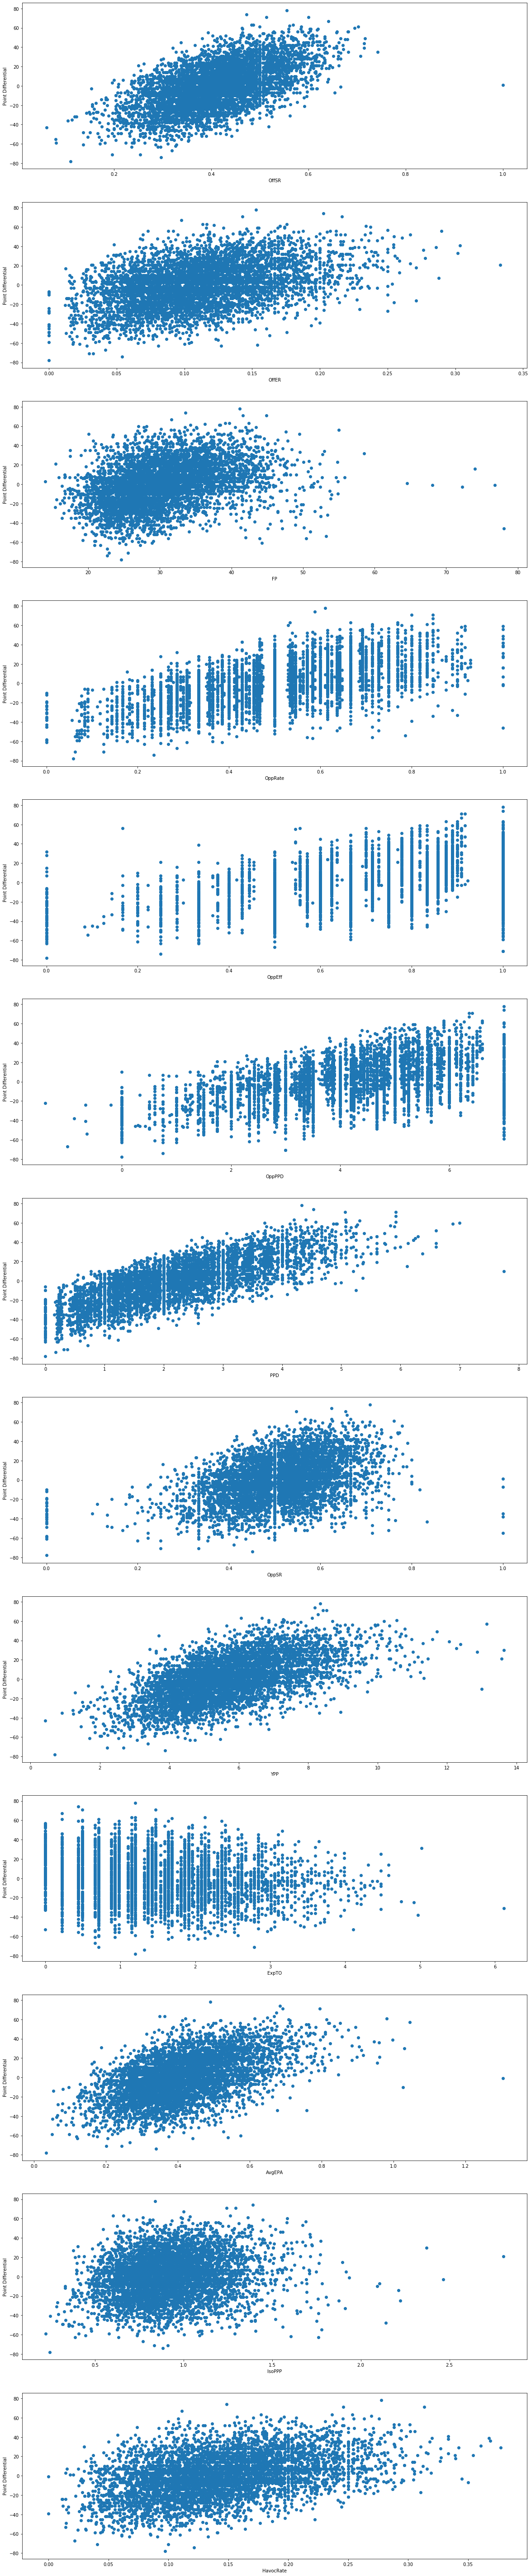

In [493]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

for i in range(len(inputs)):
    inpt = inputs[i]
    axes[i].scatter(stored_game_boxes[inpt], stored_game_boxes.PtsDiff);
    axes[i].set_xlabel(inpt)
    axes[i].set_ylabel("Point Differential");

In [494]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,1.039747,...,0.031318,-0.473659,0.22,-0.052305,-0.048746,-0.037356,4.382736,-0.734527,0.729284,0.904780
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,1.088493,...,-0.031318,0.473659,-0.22,0.052305,0.048746,0.037356,5.117264,0.734527,0.729284,0.904780
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,0.884499,...,-0.222222,1.084765,0.22,0.185541,0.460301,0.050408,4.702354,-0.095292,0.094612,0.180956
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,0.424198,...,0.222222,-1.084765,-0.22,-0.185541,-0.460301,-0.050408,4.797646,0.095292,0.094612,0.180956
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,1.092219,...,-0.379661,-5.658696,-0.22,-0.484369,-0.104645,-0.042029,3.642308,-2.215383,2.199570,2.533383


In [495]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [496]:
# outliers

In [497]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,1.039747,...,0.031318,-0.473659,0.22,-0.052305,-0.048746,-0.037356,4.382736,-0.734527,0.729284,0.904780
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,1.088493,...,-0.031318,0.473659,-0.22,0.052305,0.048746,0.037356,5.117264,0.734527,0.729284,0.904780
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,0.884499,...,-0.222222,1.084765,0.22,0.185541,0.460301,0.050408,4.702354,-0.095292,0.094612,0.180956
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,0.424198,...,0.222222,-1.084765,-0.22,-0.185541,-0.460301,-0.050408,4.797646,0.095292,0.094612,0.180956
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,1.092219,...,-0.379661,-5.658696,-0.22,-0.484369,-0.104645,-0.042029,3.642308,-2.215383,2.199570,2.533383


In [498]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [499]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {model.score(train_data["5FRDiff"][:,np.newaxis], train_data.PtsDiff)}\n')
# print(f'Linear Regression Model:\nPtsDiff = {model.intercept_:.5f}')
# for i in range(len(inputDiffs)):
#     inptDf = inputDiffs[i]
#     print(f"+ ({model.coef_[i]:.5f} * {inptDf})")
    
test.corr()

Linear Regression: y = 20.47997x + -0.12343
Mean Pred Score: -0.21426948688080347
Pred Std Dev: 20.657071092855194
MAPE: 271.4044139240111%
Mean Abs Error: 6.239637595057261
Mdn Abs Error: 5.1106458763928355
R-squared: 0.8670054550065202



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.778916,0.599962,0.438857,0.797295,0.615278,0.736730,0.983044,0.585086,0.802498,-0.487465,0.740449,0.263721,0.575555,0.932261,0.932261,0.932261
OffSRDiff,0.778916,1.000000,0.514357,0.265648,0.710307,0.399675,0.523145,0.773943,0.778073,0.730774,-0.349572,0.655039,-0.033636,0.604846,0.857957,0.857957,0.857957
OffERDiff,0.599962,0.514357,1.000000,0.177961,0.534598,0.330370,0.414909,0.591934,0.406721,0.817762,-0.239347,0.764746,0.580773,0.237666,0.597639,0.597639,0.597639
FPDiff,0.438857,0.265648,0.177961,1.000000,0.575420,0.074561,0.118457,0.418903,0.051626,0.230993,-0.261013,0.235259,0.049968,0.229369,0.556134,0.556134,0.556134
OppRateDiff,0.797295,0.710307,0.534598,0.575420,1.000000,0.231093,0.307872,0.802992,0.359239,0.695512,-0.326956,0.615994,0.166586,0.529593,0.882851,0.882851,0.882851
OppEffDiff,0.615278,0.399675,0.330370,0.074561,0.231093,1.000000,0.843715,0.605823,0.512801,0.458672,-0.322814,0.426941,0.209550,0.303786,0.532955,0.532955,0.532955
OppPPDDiff,0.736730,0.523145,0.414909,0.118457,0.307872,0.843715,1.000000,0.734036,0.639760,0.567510,-0.395519,0.536417,0.250871,0.391181,0.667871,0.667871,0.667871
PPDDiff,0.983044,0.773943,0.591934,0.418903,0.802992,0.605823,0.734036,1.000000,0.572334,0.790089,-0.483972,0.729980,0.256240,0.573567,0.927979,0.927979,0.927979
OppSRDiff,0.585086,0.778073,0.406721,0.051626,0.359239,0.512801,0.639760,0.572334,1.000000,0.581762,-0.316451,0.528130,0.012800,0.461029,0.649341,0.649341,0.649341
YPPDiff,0.802498,0.730774,0.817762,0.230993,0.695512,0.458672,0.567510,0.790089,0.581762,1.000000,-0.364724,0.918913,0.539784,0.484063,0.796861,0.796861,0.796861


In [500]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

In [501]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0

Proj MOV: Virginia Tech by -1.0 (exact value: -1.0838332052016366)
Z score: -0.04209520867755522
Win Prob for Virginia Tech: 48.32%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,1.791667,-0.052381,0.118588,0.994779,-0.66,0.103211,0.124959,-0.040309,4.773447,0.046895
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-1.791667,0.052381,-0.118588,-0.994779,0.66,-0.103211,-0.124959,0.040309,4.726553,-0.046895


In [502]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0

Proj MOV: Georgia Tech by -16.0 (exact value: -16.03278250989147)
Z score: -0.7657674678034063
Win Prob for Georgia Tech: 22.19%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,1.166667,1.361111,0.07619,-0.330005,-0.66,-0.014422,-0.121075,0.018689,4.361588,-0.776825
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-1.166667,-1.361111,-0.07619,0.330005,0.66,0.014422,0.121075,-0.018689,5.138412,0.776825


In [503]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0

Proj MOV: Georgia Tech by 2.0 (exact value: 2.1624945134764553)
Z score: 0.11505813141047506
Win Prob for Georgia Tech: 54.58%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,0.5,0.054545,-0.01919,-1.322588,0.0,-0.06305,-0.300725,0.012719,4.694191,-0.111618
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,-0.5,-0.054545,0.01919,1.322588,0.0,0.06305,0.300725,-0.012719,4.805809,0.111618


In [504]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Actual Winner: Mississippi State
MOV: Mississippi State by 1.0

Proj MOV: Mississippi State by 1.0 (exact value: 0.779609633309784)
Z score: 0.048113264253340705
Win Prob for Mississippi State: 51.92%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-1.05,0.068182,-0.059649,0.080622,0.22,0.020976,0.092249,0.000243,4.727953,-0.044094
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,1.05,-0.068182,0.059649,-0.080622,-0.22,-0.020976,-0.092249,-0.000243,4.772047,0.044094


In [505]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2.0

Proj MOV: Texas A&M by -3.0 (exact value: -2.8626231532319646)
Z score: -0.12820567129031016
Win Prob for Texas A&M: 44.90%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.166667,0.340557,0.014666,0.876496,0.0,-0.103285,-0.349878,0.001282,4.816875,0.13375
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.166667,-0.340557,-0.014666,-0.876496,0.0,0.103285,0.349878,-0.001282,4.683125,-0.13375


In [552]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

team_wp_frame = pd.DataFrame()
for team in team_list:
    team_wp_frame = team_wp_frame.append(pd.DataFrame({
        'team':[team],
        'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
    }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.938959,13,12.0,1.0
2,Clemson,0.928369,13,12.0,1.0
3,Alabama,0.912707,12,11.0,1.0
4,LSU,0.886835,13,12.0,1.0
5,Utah,0.853986,13,11.0,2.0
6,Wisconsin,0.853614,13,11.0,2.0
7,Oregon,0.825608,13,11.0,2.0
8,Georgia,0.824593,13,11.0,2.0
9,Oklahoma,0.805472,13,10.0,3.0
10,Notre Dame,0.791101,12,9.0,3.0


In [526]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":team_list})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.679674,1.320326
21,Clemson,10.618120,2.381880
53,LSU,10.111991,2.888009
128,Wisconsin,9.360955,3.639045
2,Alabama,9.349434,2.650566
115,Utah,9.263893,3.736107
78,Oklahoma,9.065403,3.934597
82,Oregon,8.910029,4.089971
34,Georgia,8.909291,4.090709
75,Notre Dame,8.596606,3.403394


In [528]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].median()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].median()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.13447730718236306, -23.050107325810306]

In [542]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5] # Sugar Bowl
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Georgia,Baylor,7.5,4.924759,0.598234,False,Georgia,Baylor
0,LSU,Oklahoma,11.0,1.661959,0.536185,False,LSU,Oklahoma
0,Florida,Virginia,14.0,0.677696,0.517221,False,Florida,Virginia
0,Penn State,Memphis,7.0,-0.565085,0.493225,False,Memphis,Memphis
0,Clemson,Ohio State,2.5,-1.029049,0.484269,False,Ohio State,Ohio State
0,Wisconsin,Oregon,2.5,-2.035373,0.464875,False,Oregon,Oregon


In [530]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Actual Winner: Virginia
MOV: Virginia by 9.0

Proj MOV: Virginia by -1.0 (exact value: -0.7813109407492006)
Z score: -0.027450234901138706
Win Prob for Virginia: 48.91%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.571429,-1.0,0.073684,-2.332187,0.66,-0.135068,-0.403644,-0.089435,4.766062,0.032123
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.571429,1.0,-0.073684,2.332187,-0.66,0.135068,0.403644,0.089435,4.733938,-0.032123


In [531]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Actual Winner: North Carolina
MOV: North Carolina by 16.0

Proj MOV: North Carolina by 11.0 (exact value: 10.571799536479947)
Z score: 0.5221490004500883
Win Prob for North Carolina: 69.92%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,0.178571,1.230769,-0.123887,-0.349659,0.0,-0.01403,-0.235394,0.079888,5.011114,0.522229
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,-0.178571,-1.230769,0.123887,0.349659,0.0,0.01403,0.235394,-0.079888,4.488886,-0.522229


In [532]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0

Proj MOV: Pittsburgh by 17.0 (exact value: 16.6312571526382)
Z score: 0.8154847588894382
Win Prob for Pittsburgh: 79.26%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.833333,0.659341,0.20743,1.49512,0.0,0.130501,-0.248736,0.038746,5.159051,0.818101
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.833333,-0.659341,-0.20743,-1.49512,0.0,-0.130501,0.248736,-0.038746,4.340949,-0.818101


In [533]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Actual Winner: Auburn
MOV: Auburn by 3.0

Proj MOV: Auburn by -9.0 (exact value: -9.3805990030745)
Z score: -0.44373810183400686
Win Prob for Auburn: 32.86%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.063492,-0.538462,0.114729,1.117419,0.44,0.063274,-0.083465,-0.033763,4.976005,0.452011
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.063492,0.538462,-0.114729,-1.117419,-0.44,-0.063274,0.083465,0.033763,4.523995,-0.452011


In [534]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Actual Winner: Georgia
MOV: Georgia by 45.0

Proj MOV: Georgia by 39.0 (exact value: 38.96270737835594)
Z score: 1.8965407384780293
Win Prob for Georgia: 97.11%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,AvgEPADiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,2.666667,3.276786,-0.047059,4.45067,0.0,0.330151,0.455922,0.020115,5.704253,1.908506
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-2.666667,-3.276786,0.047059,-4.45067,0.0,-0.330151,-0.455922,-0.020115,3.795747,-1.908506


In [544]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

Actual Winner: Clemson
MOV: Clemson by 38.0

Proj MOV: Clemson by 25.0 (exact value: 25.141885979581726)
Z score: 1.2274806700564942
Win Prob for Clemson: 89.02%
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0

Proj MOV: Georgia Tech by 7.0 (exact value: 7.013190726357079)
Z score: 0.3498782659337264
Win Prob for Georgia Tech: 63.68%
Actual Winner: The Citadel
MOV: The Citadel by 3.0

Proj MOV: The Citadel by -9.0 (exact value: -9.368243728351565)
Z score: -0.4431399882550102
Win Prob for The Citadel: 32.88%
Actual Winner: Temple
MOV: Temple by 22.0

Proj MOV: Temple by 21.0 (exact value: 21.10831292968812)
Z score: 1.0322171192964482
Win Prob for Temple: 84.90%
Actual Winner: North Carolina
MOV: North Carolina by 16.0

Proj MOV: North Carolina by 11.0 (exact value: 10.571799536479947)
Z score: 0.5221490004500883
Win Prob for North Carolina: 69.92%
Actual Winner: Duke
MOV: Duke by 18.0

Proj MOV: Duke by 13.0 (exact value: 12.722204668542531)
Z score: 0.6262491956034253
Win Prob f

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2520,401111653,2019,Georgia Tech,Clemson,-38.0,10.982099
2616,401112441,2019,Georgia Tech,South Florida,4.0,63.678497
2683,401112452,2019,Georgia Tech,The Citadel,-3.0,67.116776
2823,401112469,2019,Georgia Tech,Temple,-22.0,15.098521
2880,401112475,2019,Georgia Tech,North Carolina,-16.0,30.078330
2914,401112480,2019,Georgia Tech,Duke,-18.0,26.557575
2967,401112488,2019,Georgia Tech,Miami,7.0,22.190734
3100,401112498,2019,Georgia Tech,Pittsburgh,-10.0,20.739744
3134,401112504,2019,Georgia Tech,Virginia,-5.0,23.919424
3191,401112511,2019,Georgia Tech,Virginia Tech,-45.0,0.142249


In [545]:
retrieve_win_probs("Georgia", 2019)

Actual Winner: Georgia
MOV: Georgia by 24.0

Proj MOV: Georgia by 40.0 (exact value: 39.663313103224354)
Z score: 1.9304567627642961
Win Prob for Georgia: 97.32%
Actual Winner: Georgia
MOV: Georgia by 46.0

Proj MOV: Georgia by 44.0 (exact value: 44.40621178120416)
Z score: 2.160058464605767
Win Prob for Georgia: 98.46%
Actual Winner: Georgia
MOV: Georgia by 55.0

Proj MOV: Georgia by 56.0 (exact value: 56.12187625315185)
Z score: 2.7272087841880945
Win Prob for Georgia: 99.68%
Actual Winner: Georgia
MOV: Georgia by 6.0

Proj MOV: Georgia by 6.0 (exact value: 6.415068096535248)
Z score: 0.3209234045628563
Win Prob for Georgia: 62.59%
Actual Winner: Georgia
MOV: Georgia by 29.0

Proj MOV: Georgia by 35.0 (exact value: 34.966540696311995)
Z score: 1.7030880140292992
Win Prob for Georgia: 95.57%
Actual Winner: South Carolina
MOV: South Carolina by 3.0

Proj MOV: South Carolina by -6.0 (exact value: -6.4708898958379075)
Z score: -0.3028803251357897
Win Prob for South Carolina: 38.10%
Actua

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2578,401110732,2019,Georgia,Vanderbilt,24.0,97.322487
2631,401110776,2019,Georgia,Murray State,46.0,98.461593
2682,401110788,2019,Georgia,Arkansas State,55.0,99.680637
2789,401110800,2019,Georgia,Notre Dame,6.0,62.586578
2886,401110816,2019,Georgia,Tennessee,29.0,95.572420
2912,401110817,2019,Georgia,South Carolina,-3.0,61.900947
2994,401110826,2019,Georgia,Kentucky,21.0,90.171608
3088,401110838,2019,Georgia,Florida,7.0,67.753203
3154,401110845,2019,Georgia,Missouri,27.0,91.380589
3194,401110849,2019,Georgia,Auburn,7.0,62.463701


In [546]:
retrieve_win_probs("Georgia Tech", 2018)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0

Proj MOV: Georgia Tech by 51.0 (exact value: 51.393979229316614)
Z score: 2.4983333060245663
Win Prob for Georgia Tech: 99.38%
Actual Winner: South Florida
MOV: South Florida by 11.0

Proj MOV: South Florida by 9.0 (exact value: 8.963638544944265)
Z score: 0.44429861283671995
Win Prob for South Florida: 67.16%
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0

Proj MOV: Pittsburgh by 5.0 (exact value: 5.031615616277955)
Z score: 0.25395106012745383
Win Prob for Pittsburgh: 60.02%
Actual Winner: Clemson
MOV: Clemson by 28.0

Proj MOV: Clemson by 29.0 (exact value: 28.594630987560034)
Z score: 1.394626583068941
Win Prob for Clemson: 91.84%
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0

Proj MOV: Georgia Tech by 37.0 (exact value: 37.08440259316037)
Z score: 1.8056128050477556
Win Prob for Georgia Tech: 96.45%
Actual Winner: Georgia Tech
MOV: Georgia Tech by 35.0

Proj MOV: Georgia Tech by 37.0 (exact value: 37.12203478923592)


,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
1702,401013090,2018,Georgia Tech,Alcorn State,41.0,99.376106
1764,401013100,2018,Georgia Tech,South Florida,-11.0,32.841335
1851,401013112,2018,Georgia Tech,Pittsburgh,-5.0,39.976668
1922,401013120,2018,Georgia Tech,Clemson,-28.0,8.156424
1965,401013134,2018,Georgia Tech,Bowling Green,46.0,96.451058
2020,401013138,2018,Georgia Tech,Louisville,35.0,96.465273
2089,401013145,2018,Georgia Tech,Duke,-14.0,18.723598
2189,401013153,2018,Georgia Tech,Virginia Tech,21.0,77.098452
2261,401013165,2018,Georgia Tech,North Carolina,10.0,80.377505
2352,401013172,2018,Georgia Tech,Miami,6.0,53.773666


In [547]:
retrieve_win_probs("Clemson", 2019)

Actual Winner: Clemson
MOV: Clemson by 38.0

Proj MOV: Clemson by 25.0 (exact value: 25.141885979581726)
Z score: 1.2274806700564942
Win Prob for Clemson: 89.02%
Actual Winner: Clemson
MOV: Clemson by 14.0

Proj MOV: Clemson by 10.0 (exact value: 10.34469214175327)
Z score: 0.511154828347673
Win Prob for Clemson: 69.54%
Actual Winner: Clemson
MOV: Clemson by 35.0

Proj MOV: Clemson by 30.0 (exact value: 29.544094670329343)
Z score: 1.4405897149428353
Win Prob for Clemson: 92.51%
Actual Winner: Clemson
MOV: Clemson by 42.0

Proj MOV: Clemson by 47.0 (exact value: 47.270717772689665)
Z score: 2.298727977752588
Win Prob for Clemson: 98.92%
Actual Winner: Clemson
MOV: Clemson by 1.0

Proj MOV: Clemson by -0.0 (exact value: -0.2784879097087386)
Z score: -0.00310878645570169
Win Prob for Clemson: 49.88%
Actual Winner: Clemson
MOV: Clemson by 31.0

Proj MOV: Clemson by 23.0 (exact value: 22.511894769784902)
Z score: 1.100163917455179
Win Prob for Clemson: 86.44%
Actual Winner: Clemson
MOV: Cl

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
2520,401111653,2019,Clemson,Georgia Tech,38.0,89.017901
2621,401110784,2019,Clemson,Texas A&M,14.0,69.537868
2724,401112449,2019,Clemson,Syracuse,35.0,92.514969
2783,401112456,2019,Clemson,Charlotte,42.0,98.923980
2819,401112467,2019,Clemson,North Carolina,1.0,49.875978
2920,401112479,2019,Clemson,Florida State,31.0,86.436965
2966,401112485,2019,Clemson,Louisville,35.0,92.468606
3060,401112490,2019,Clemson,Boston College,52.0,92.886060
3097,401112496,2019,Clemson,Wofford,45.0,98.167783
3161,401112503,2019,Clemson,NC State,45.0,96.758511


In [548]:
retrieve_win_probs("Georgia Tech", 2016)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 3.0

Proj MOV: Georgia Tech by -5.0 (exact value: -5.262400629792998)
Z score: -0.24437787526704244
Win Prob for Georgia Tech: 40.35%
Actual Winner: Georgia Tech
MOV: Georgia Tech by 25.0

Proj MOV: Georgia Tech by 30.0 (exact value: 30.018113540766162)
Z score: 1.4635367662603267
Win Prob for Georgia Tech: 92.83%
Actual Winner: Georgia Tech
MOV: Georgia Tech by 31.0

Proj MOV: Georgia Tech by 30.0 (exact value: 29.86867466117976)
Z score: 1.4563024938451008
Win Prob for Georgia Tech: 92.73%
Actual Winner: Clemson
MOV: Clemson by 19.0

Proj MOV: Clemson by 20.0 (exact value: 19.52625951895533)
Z score: 0.9556305885331405
Win Prob for Clemson: 83.04%
Actual Winner: Miami
MOV: Miami by 14.0

Proj MOV: Miami by 6.0 (exact value: 6.125751475463625)
Z score: 0.30691771034942583
Win Prob for Miami: 62.05%
Actual Winner: Pittsburgh
MOV: Pittsburgh by 3.0

Proj MOV: Pittsburgh by 4.0 (exact value: 3.5119315454950426)
Z score: 0.18038380250647698

,GameID,Year,Team,Opponent,ActualMOV,PostGameWinProb
28,400869424,2016,Georgia Tech,Boston College,3.0,40.346909
109,400869433,2016,Georgia Tech,Mercer,25.0,92.833972
178,400869001,2016,Georgia Tech,Vanderbilt,31.0,92.734549
229,400869446,2016,Georgia Tech,Clemson,-19.0,16.962945
292,400869721,2016,Georgia Tech,Miami,-14.0,37.945300
366,400869458,2016,Georgia Tech,Pittsburgh,-3.0,42.842563
418,400869464,2016,Georgia Tech,Georgia Southern,11.0,74.510005
523,400869474,2016,Georgia Tech,Duke,3.0,34.927696
590,400869480,2016,Georgia Tech,North Carolina,-28.0,23.061865
662,400869486,2016,Georgia Tech,Virginia Tech,10.0,45.930052
